In [3]:
%load_ext autoreload
%autoreload 1
%aimport RedditProcessing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from redditClient import redditClient
# import praw
# from praw.models import MoreComments
from collections import Counter
import string
import json
import codecs
import re
import time
import sys
import datetime

# from redditscore.tokenizer import CrazyTokenizer

import nltk
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')

from colorama import Fore, Back, Style
from tabulate import tabulate
import datetime as dt

C:\Users\rakya\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rakya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rakya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
data_colnames = ["text", "datetime", "replies", "views", "subforum", "topic"]
playerNames = ["Ronaldo", "Messi", "Pele", "Maradona", "Rooney"]
colorList = ['gold', 'hotpink', 'green', 'lightblue', 'red']
dataList_raw = []

for i in range(len(playerNames)):
    filename_head = "data_"
    filename_tail = "_rep_view_final.csv"
    filename_final = filename_head+playerNames[i].lower()+filename_tail
    dataList_raw.append(pd.read_csv(filename_final, names=data_colnames))
    
for i in range(len(playerNames)):
    print("Length of data for " + playerNames[i] + ": " + str(len(dataList_raw[i])))
    
regexpr = r'\w+' # Regular Expression for tokenizer
num_freq_term = 25

Length of data for Ronaldo: 8021
Length of data for Messi: 2977
Length of data for Pele: 1071
Length of data for Maradona: 1754
Length of data for Rooney: 4365


Cleaning data

In [6]:
# data_ronaldo_raw.head()
dataList_raw[0].head()

,text,datetime,replies,views,subforum,topic
0,with UEFA over groundbreaking Champions League...,"Mon Aug 28, 2023 6:30 pm",20,2408,World Football,Saudi's and FFP
1,with UEFA over groundbreaking Champions League...,"Wed Aug 23, 2023 5:21 pm",20,2408,World Football,Saudi's and FFP
2,ronaldo is a legend in his own lunchbox. ten h...,"Fri Apr 14, 2023 11:30 pm",41,3696,World Football,UEFA Europa League 22/23
3,consistency but are never going to get it. Can...,"Sun Jan 15, 2023 10:13 am",776,49958,World Football,EPL 22/23
4,"pass is exceptional, I think he is better than...","Tue Dec 20, 2022 10:54 am",14,1851,World Football,Players of the tournament


In [7]:
dataList_raw[1].head()

,text,datetime,replies,views,subforum,topic
0,"at the same time, or they can watch Vanilla Ar...","Thu Jun 15, 2023 1:52 pm",12,1353,Australian National Football Teams - Socceroos...,Argentina 🇦🇷 v Australia 🇦🇺 Thursday 15 June 9...
1,"at the same time, or they can watch Vanilla Ar...","Wed Jun 14, 2023 1:38 pm",12,1353,Australian National Football Teams - Socceroos...,Argentina 🇦🇷 v Australia 🇦🇺 Thursday 15 June 9...
2,$400 Million????,"Fri May 05, 2023 10:52 am",2,1187,World Football,Lionel Messi wear his new Shirts makes Paris S...
3,Messi Gonski 1.95507632,"Wed May 03, 2023 11:11 pm",2,1187,World Football,Lionel Messi wear his new Shirts makes Paris S...
4,"bloody professional footballers, but they stil...","Mon Jan 23, 2023 9:15 pm",776,49960,World Football,EPL 22/23


In [8]:
dataList_raw[2].head()

,text,datetime,replies,views,subforum,topic
0,Absolute legend and by all accounts a fantasti...,"Sat Dec 31, 2022 10:22 pm",5,1164,World Football,Pele
1,for,"Fri Dec 30, 2022 6:37 pm",5,1164,World Football,Pele
2,"The king of our game has gone ,RIP & thank you...","Fri Dec 30, 2022 6:37 pm",5,1164,World Football,Pele
3,"He had a pretty good run at life, didn't die w...","Fri Dec 30, 2022 8:22 am",5,1164,World Football,Pele
4,Sad news this morning .Pele RIP.,"Fri Dec 30, 2022 7:49 am",5,1164,World Football,Pele


In [9]:
dataList_raw[3].head()

,text,datetime,replies,views,subforum,topic
0,do yourself a favour and watch this movie,"Fri Dec 10, 2021 1:46 pm",4,2866,Football Films,Diego Maradona - the film
1,One of 5 if that's your angle.,"Sat Nov 28, 2020 1:34 pm",62,6387,World Football,Diego Maradona dies
2,Why would you get caught up in emotion about a...,"Sat Nov 28, 2020 1:16 pm",62,6387,World Football,Diego Maradona dies
3,that was turning Milan Ivanovic inside out and...,"Sat Nov 28, 2020 11:57 am",62,6387,World Football,Diego Maradona dies
4,He meant a whole lot to a lot of people and at...,"Sat Nov 28, 2020 11:31 am",62,6387,World Football,Diego Maradona dies


In [10]:
dataList_clean_text = []
for i in range(len(playerNames)):
    dataList_clean_text.append(dataList_raw[i][dataList_raw[i]['text'].str.len() >= 50])

In [11]:
for i in range(len(playerNames)):
    print(len(dataList_clean_text[i]))

6717
2371
852
1436
3675


In [12]:
def dataCleanDatetime(data):
    data_date_only = data['datetime'].str.split(expand=True)
    data_date_only = data_date_only.rename(columns={0:'day', 1:'month', 2:'date', 3:'year', 4:'time', 5:'ampm'})
    data_datetime_raw = data.join(data_date_only)
    
    data_time_only = data_datetime_raw['time'].str.split(':', expand=True)
    data_time_only = data_time_only.rename(columns={0:'hour', 1:'minute'})
    data_datetime_raw = data_datetime_raw.join(data_time_only)
    data_datetime_raw = data_datetime_raw.reset_index(drop=True)
    
    for i in range(len(data_datetime_raw)):
        if data_datetime_raw['ampm'][i] == 'pm':
            data_datetime_raw['hour'][i] = str(int(data_datetime_raw['hour'][i]) + 12)
    
    monthName = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for i in range(len(data_datetime_raw)):
        currMonth = data_datetime_raw['month'][i]
        if currMonth in monthName:
            monthNum = str(monthName.index(currMonth)+1)
            if len(monthNum) == 1:
                monthNum = "0"+monthNum
            data_datetime_raw['month'][i] = monthNum
#             print(monthNum, data_datetime_raw['month'][i])
                
    data_datetime_raw['date'] = data_datetime_raw['date'].str.replace(',','')
    data_datetime_raw.rename(columns={"day": "dayType", "date": "day"}, inplace=True)
    
    data_datetime_raw['datetime'] = pd.to_datetime(data_datetime_raw[['month', 'day', 'year', 'hour', 'minute']])
    data_res = data_datetime_raw.drop(['month', 'day', 'year', 'time', 'ampm', 'hour', 'minute'], axis=1)
    return data_res

In [13]:
# data_clean_datetime_ronaldo = dataCleanDatetime(data_clean_text_ronaldo)
# data_clean_datetime_messi = dataCleanDatetime(data_clean_text_messi)
# data_clean_datetime_pele = dataCleanDatetime(data_clean_text_pele)
# data_clean_datetime_maradona = dataCleanDatetime(data_clean_text_maradona)
dataList_clean = []
for i in range(len(playerNames)):
    dataList_clean.append(dataCleanDatetime(dataList_clean_text[i]))

C:\Users\rakya\AppData\Local\Temp\ipykernel_12396\224720755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_datetime_raw['hour'][i] = str(int(data_datetime_raw['hour'][i]) + 12)
C:\Users\rakya\AppData\Local\Temp\ipykernel_12396\224720755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_datetime_raw['month'][i] = monthNum
C:\Users\rakya\AppData\Local\Temp\ipykernel_12396\224720755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [102]:
value_to_check = pd.Timestamp(2013, 1, 1)
dataList_clean_ronaldo =  dataList_clean[3][dataList_clean[3]['datetime'] > value_to_check]

In [15]:
# data_clean_datetime_ronaldo.head()
dataList_clean[0].head()

,text,datetime,replies,views,subforum,topic,dayType
0,with UEFA over groundbreaking Champions League...,2023-08-28 18:30:00,20,2408,World Football,Saudi's and FFP,Mon
1,with UEFA over groundbreaking Champions League...,2023-08-23 17:21:00,20,2408,World Football,Saudi's and FFP,Wed
2,ronaldo is a legend in his own lunchbox. ten h...,2023-04-14 23:30:00,41,3696,World Football,UEFA Europa League 22/23,Fri
3,consistency but are never going to get it. Can...,2023-01-15 10:13:00,776,49958,World Football,EPL 22/23,Sun
4,"pass is exceptional, I think he is better than...",2022-12-20 10:54:00,14,1851,World Football,Players of the tournament,Tue


In [16]:
dataList_clean[1].head()

,text,datetime,replies,views,subforum,topic,dayType
0,"at the same time, or they can watch Vanilla Ar...",2023-06-15 13:52:00,12,1353,Australian National Football Teams - Socceroos...,Argentina 🇦🇷 v Australia 🇦🇺 Thursday 15 June 9...,Thu
1,"at the same time, or they can watch Vanilla Ar...",2023-06-14 13:38:00,12,1353,Australian National Football Teams - Socceroos...,Argentina 🇦🇷 v Australia 🇦🇺 Thursday 15 June 9...,Wed
2,"bloody professional footballers, but they stil...",2023-01-23 21:15:00,776,49960,World Football,EPL 22/23,Mon
3,Been saying the same about Messi for along tim...,2023-01-23 20:00:00,776,49960,World Football,EPL 22/23,Mon
4,A great final. Well played by both. Two champi...,2022-12-19 22:46:00,546,30935,World Football,World Cup 2022 Forum,Mon


In [17]:
dataList_clean[2].head()

,text,datetime,replies,views,subforum,topic,dayType
0,Absolute legend and by all accounts a fantasti...,2022-12-31 22:22:00,5,1164,World Football,Pele,Sat
1,"The king of our game has gone ,RIP & thank you...",2022-12-30 18:37:00,5,1164,World Football,Pele,Fri
2,"He had a pretty good run at life, didn't die w...",2022-12-30 08:22:00,5,1164,World Football,Pele,Fri
3,"If England can't win it, I'd be happy to see B...",2022-12-06 06:45:00,546,30935,World Football,World Cup 2022 Forum,Tue
4,There will never be another PELE Brazil legend...,2022-12-05 13:37:00,5,1164,World Football,Pele,Mon


In [18]:
dataList_clean[3].head()

,text,datetime,replies,views,subforum,topic,dayType
0,Why would you get caught up in emotion about a...,2020-11-28 13:16:00,62,6387,World Football,Diego Maradona dies,Sat
1,that was turning Milan Ivanovic inside out and...,2020-11-28 11:57:00,62,6387,World Football,Diego Maradona dies,Sat
2,He meant a whole lot to a lot of people and at...,2020-11-28 11:31:00,62,6387,World Football,Diego Maradona dies,Sat
3,"Party at mine tonight, going to be a big celeb...",2020-11-28 09:24:00,62,6387,World Football,Diego Maradona dies,Sat
4,You didn't play anyone in the 1994 world cup. ...,2020-11-27 18:28:00,62,6387,World Football,Diego Maradona dies,Fri


In [19]:
dataList_clean[4].head()

,text,datetime,replies,views,subforum,topic,dayType
0,"most had been ""let down by a minority"". In a p...",2022-12-24 21:39:00,546,30935,World Football,World Cup 2022 Forum,Sat
1,and anyway I only had the giggs top in the fir...,2022-02-02 13:58:00,445,42394,World Football,EPL 21/22,Wed
2,ground stance why do you make it so easy? Wha...,2021-11-22 10:02:00,38,4434,Other Sports,Stand in skipper standing down?,Mon
3,Englands greatest international goal scorer an...,2021-11-22 09:39:00,38,4434,Other Sports,Stand in skipper standing down?,Mon
4,majority of outgoings being associated with pl...,2021-09-19 00:45:00,5,1123,World Football,Championship club file notice to appoint admin...,Sat


In [20]:
def proc_text(text, tokenizer, stemmer, stopwords):
    """
    Perform tokenisation, normalisation (lower case and stemming) and stopword and twitter keyword removal.

    @param text: reddit submission or comment text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """

    # covert all to lower case
    text = text.lower()
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    # stem (we use set to remove duplicates)
    lStemmedTokens = set([stemmer.stem(tok) for tok in lTokens])


    # remove stopwords, digits
    return [tok for tok in lStemmedTokens if tok not in stopwords and not tok.isdigit()]

In [21]:
def funcCount(data, colName1, colname2, tsCount):
    for i in range(len(data)):
#         if colName1 == 'dayType':
#             post_daytype = dataList_clean[i]['dayType'][j]
#             if colName2 == 'count':
        if colName1 == 'datetime':
            post_date = data['datetime'][i]
            if colname2 != 'count':
                if post_date in tsCount[colName1].unique():
                    tsCount.loc[tsCount[colName1] == post_date, colname2] += data[colname2][i]
                else:
                    new_row = {colName1:post_date, colname2:data[colname2][i]}
                    tsCount.loc[len(tsCount)] = new_row
        else:
            post_subforum = data[colName1][i]
            if post_subforum in tsCount[colName1].unique():
                tsCount.loc[tsCount[colName1] == post_subforum, 'count'] += 1
            else:
                new_row = {colName1:post_subforum, 'count':1}
                tsCount.loc[len(tsCount)] = new_row

In [22]:
def plotTimeSeries(dataTS, period):
    newDataTS = dataTS.resample(period).sum()
    newDataTS.plot()
    plt.show()

In [23]:
def comparePlotTS(playerNames, dataTS, resamplePeriod, colname):
    plt.figure(figsize=(16, 8), dpi=150) 
    title_plot = ""
    if "Y" in resamplePeriod:
        title_head = "Yearly"
    elif "M" in resamplePeriod:
        title_head = "Monthly"
    elif "D" in resamplePeriod:
        title_head = "Daily"
    
    title_subject = ""
    if colname == "sentiment": 
        title_subject = colname
    else:
        title_subject = "engagement in " + colname
    
    title_tail = " for football players in footballnews.com.au"
    
    title_plot = title_head + " " + title_subject + title_tail
    title_yLabel = colname.capitalize()
    
    plt.title(title_plot)
    new_series_list = []
    for i in range(len(playerNames)):
        new_series_list.append(dataTS[i].resample(resamplePeriod).sum())
        
    for i in range(len(playerNames)):
        new_series_list[i][colname].plot(label=playerNames[i], color=colorList[i])
    
    plt.xlabel('Years') 
    plt.ylabel(title_yLabel) 
    
    plt.legend() 

Frequency plot for replies and views

In [24]:
repl_count_dfList = []
view_count_dfList = []

for i in range(len(playerNames)):
    repl_count_dfList.append(pd.DataFrame(columns=['datetime', 'replies']))
    view_count_dfList.append(pd.DataFrame(columns=['datetime', 'views']))
    funcCount(dataList_clean[i], 'datetime', 'replies', repl_count_dfList[i])
    funcCount(dataList_clean[i], 'datetime', 'views', view_count_dfList[i])
    repl_count_dfList[i] = repl_count_dfList[i].sort_values(by='datetime').reset_index(drop=True).set_index('datetime')
    view_count_dfList[i] = view_count_dfList[i].sort_values(by='datetime').reset_index(drop=True).set_index('datetime')

In [103]:
repl_count_dfList_ronaldo = pd.DataFrame(columns=['datetime', 'replies'])
view_count_dfList_ronaldo = pd.DataFrame(columns=['datetime', 'views'])

funcCount(dataList_clean_ronaldo, 'datetime', 'replies', repl_count_dfList_ronaldo)
funcCount(dataList_clean_ronaldo, 'datetime', 'views', view_count_dfList_ronaldo)

repl_count_dfList_ronaldo = repl_count_dfList_ronaldo.sort_values(by='datetime').reset_index(drop=True).set_index('datetime')
view_count_dfList_ronaldo = view_count_dfList_ronaldo.sort_values(by='datetime').reset_index(drop=True).set_index('datetime')

In [25]:
subforum_count_dfList = []
topic_count_dfList = []

for i in range(len(playerNames)):
    subforum_count_dfList.append(pd.DataFrame(columns=['subforum', 'count']))
    topic_count_dfList.append(pd.DataFrame(columns=['topic', 'count']))
    funcCount(dataList_clean[i], 'subforum', 'count', subforum_count_dfList[i])
    funcCount(dataList_clean[i], 'topic', 'count', topic_count_dfList[i])
    subforum_count_dfList[i] = subforum_count_dfList[i].sort_values(by='count', ascending=False).reset_index(drop=True)
    topic_count_dfList[i] = topic_count_dfList[i].sort_values(by='count', ascending=False).reset_index(drop=True)

In [26]:
day_postCount_dfList = []
day_postReplies_dfList = []
day_postViews_dfList = []
dayList = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for i in range(len(playerNames)):
    day_postCount_dfList.append(pd.DataFrame(columns=['dayType', 'count']))
    day_postReplies_dfList.append(pd.DataFrame(columns=['dayType', 'replies']))
    day_postViews_dfList.append(pd.DataFrame(columns=['dayType', 'views']))
    for j in range(len(dayList)):
        new_rowCount = {'dayType':dayList[j], 'count':0}
        day_postCount_dfList[i].loc[len(day_postCount_dfList[i])] = new_rowCount
        new_rowRepl = {'dayType':dayList[j], 'replies':0}
        day_postReplies_dfList[i].loc[len(day_postReplies_dfList[i])] = new_rowRepl
        new_rowView = {'dayType':dayList[j], 'views':0}
        day_postViews_dfList[i].loc[len(day_postViews_dfList[i])] = new_rowView
        
for i in range(len(playerNames)):
    for j in range(len(dataList_clean[i])):
        post_daytype = dataList_clean[i]['dayType'][j]
        post_repl = dataList_clean[i]['replies'][j]
        post_view = dataList_clean[i]['views'][j]
        day_postCount_dfList[i].loc[day_postCount_dfList[i]['dayType'] == post_daytype, 'count'] += 1
        day_postReplies_dfList[i].loc[day_postReplies_dfList[i]['dayType'] == post_daytype, 'replies'] += dataList_clean[i]['replies'][j]
        day_postViews_dfList[i].loc[day_postViews_dfList[i]['dayType'] == post_daytype, 'views'] += dataList_clean[i]['views'][j]

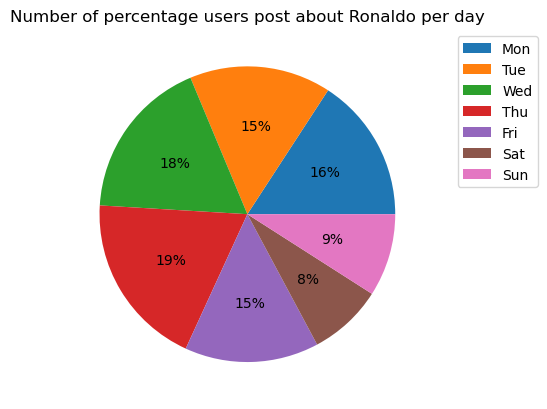

In [29]:
# autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[0].head(10)['count'])/100.0)
plt.pie(day_postCount_dfList[0]['count'], labels=None, autopct="%.0f%%")
plt.legend(labels=day_postCount_dfList[0]['dayType'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Number of percentage users post about Ronaldo per day")
plt.show()

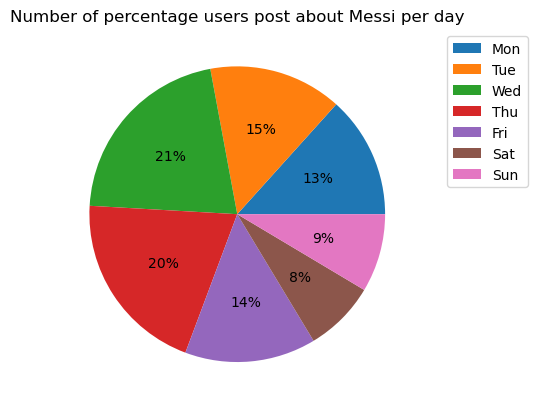

In [30]:
# autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[0].head(10)['count'])/100.0)
plt.pie(day_postCount_dfList[1]['count'], labels=None, autopct="%.0f%%")
plt.legend(labels=day_postCount_dfList[1]['dayType'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Number of percentage users post about Messi per day")
plt.show()

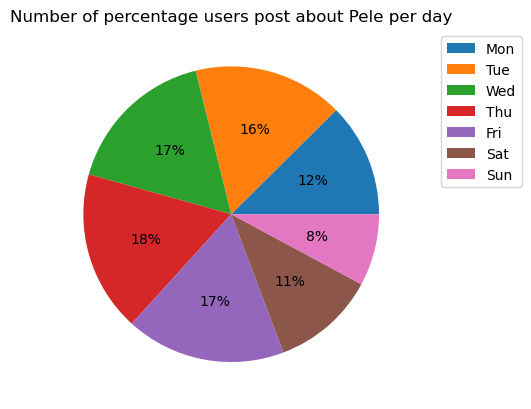

In [31]:
# autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[0].head(10)['count'])/100.0)
plt.pie(day_postCount_dfList[2]['count'], labels=None, autopct="%.0f%%")
plt.legend(labels=day_postCount_dfList[2]['dayType'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Number of percentage users post about Pele per day")
plt.show()

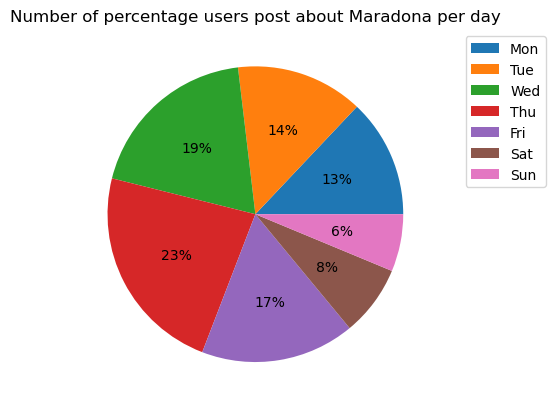

In [32]:
# autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[0].head(10)['count'])/100.0)
plt.pie(day_postCount_dfList[3]['count'], labels=None, autopct="%.0f%%")
plt.legend(labels=day_postCount_dfList[3]['dayType'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Number of percentage users post about Maradona per day")
plt.show()

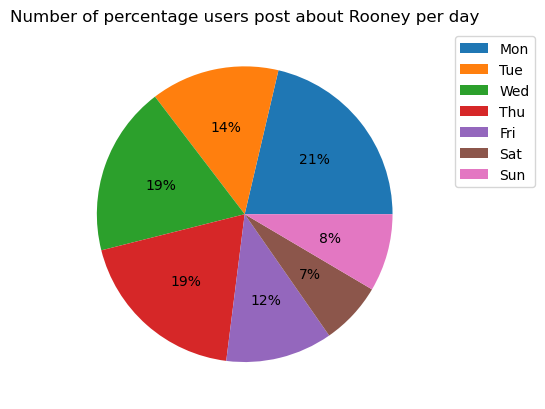

In [33]:
# autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[0].head(10)['count'])/100.0)
plt.pie(day_postCount_dfList[4]['count'], labels=None, autopct="%.0f%%")
plt.legend(labels=day_postCount_dfList[4]['dayType'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Number of percentage users post about Rooney per day")
plt.show()

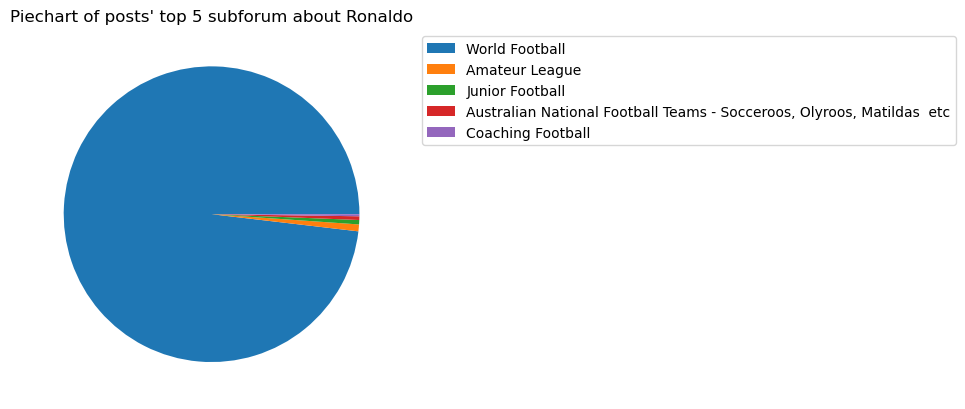

In [34]:
plt.pie(subforum_count_dfList[0].head(5)['count'], labels=None)
plt.legend(labels=subforum_count_dfList[0].head(5)['subforum'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of posts' top 5 subforum about Ronaldo")
plt.show()

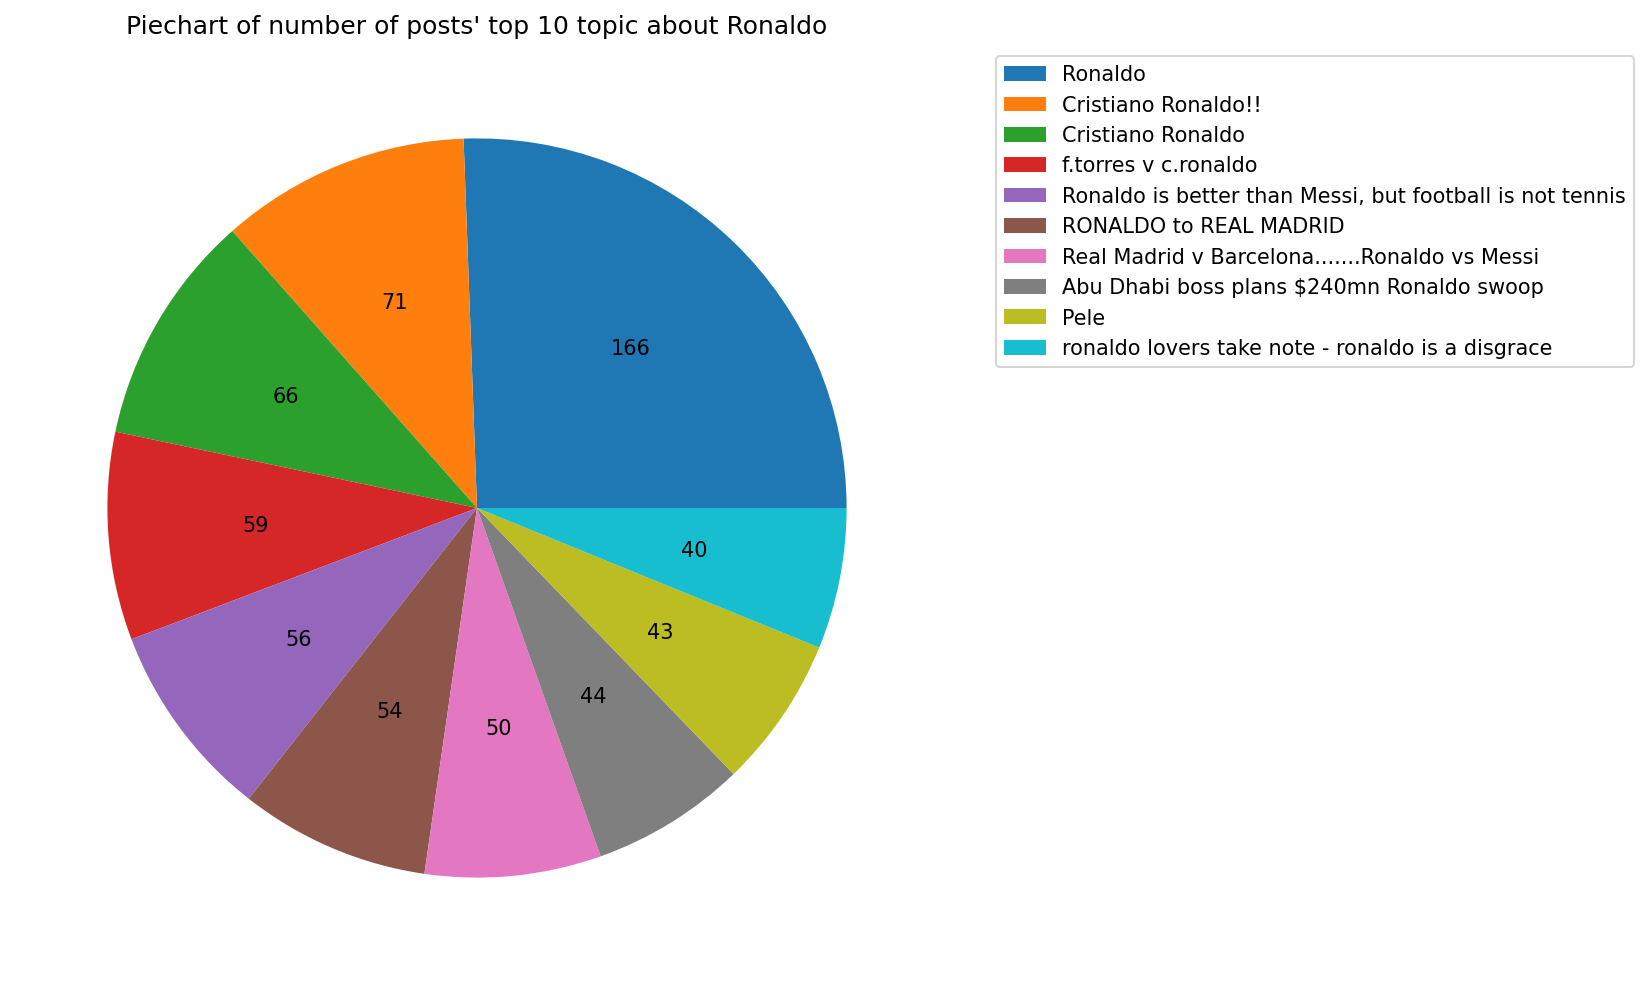

In [35]:
plt.figure(figsize=(16, 8), dpi=150) 
autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[0].head(10)['count'])/100.0)
plt.pie(topic_count_dfList[0].head(10)['count'], labels=None, autopct=autopct)
plt.legend(labels=topic_count_dfList[0].head(10)['topic'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of number of posts' top 10 topic about Ronaldo")
# plt.show()
plt.savefig("top10Topic_ronaldo_graph.png")

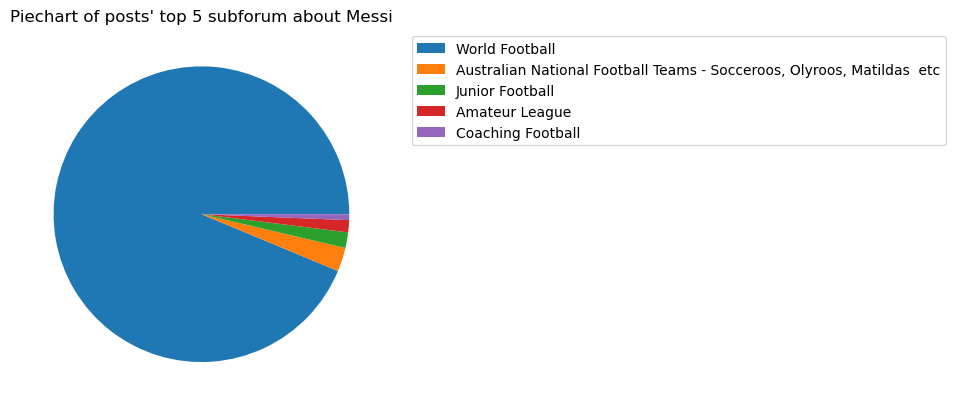

In [36]:
plt.figsize=(8.0, 5.0)
plt.pie(subforum_count_dfList[1].head(5)['count'], labels=None)
plt.legend(labels=subforum_count_dfList[1].head(5)['subforum'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of posts' top 5 subforum about Messi")
plt.show()

In [37]:
# topic_count_df_messi.head(10)

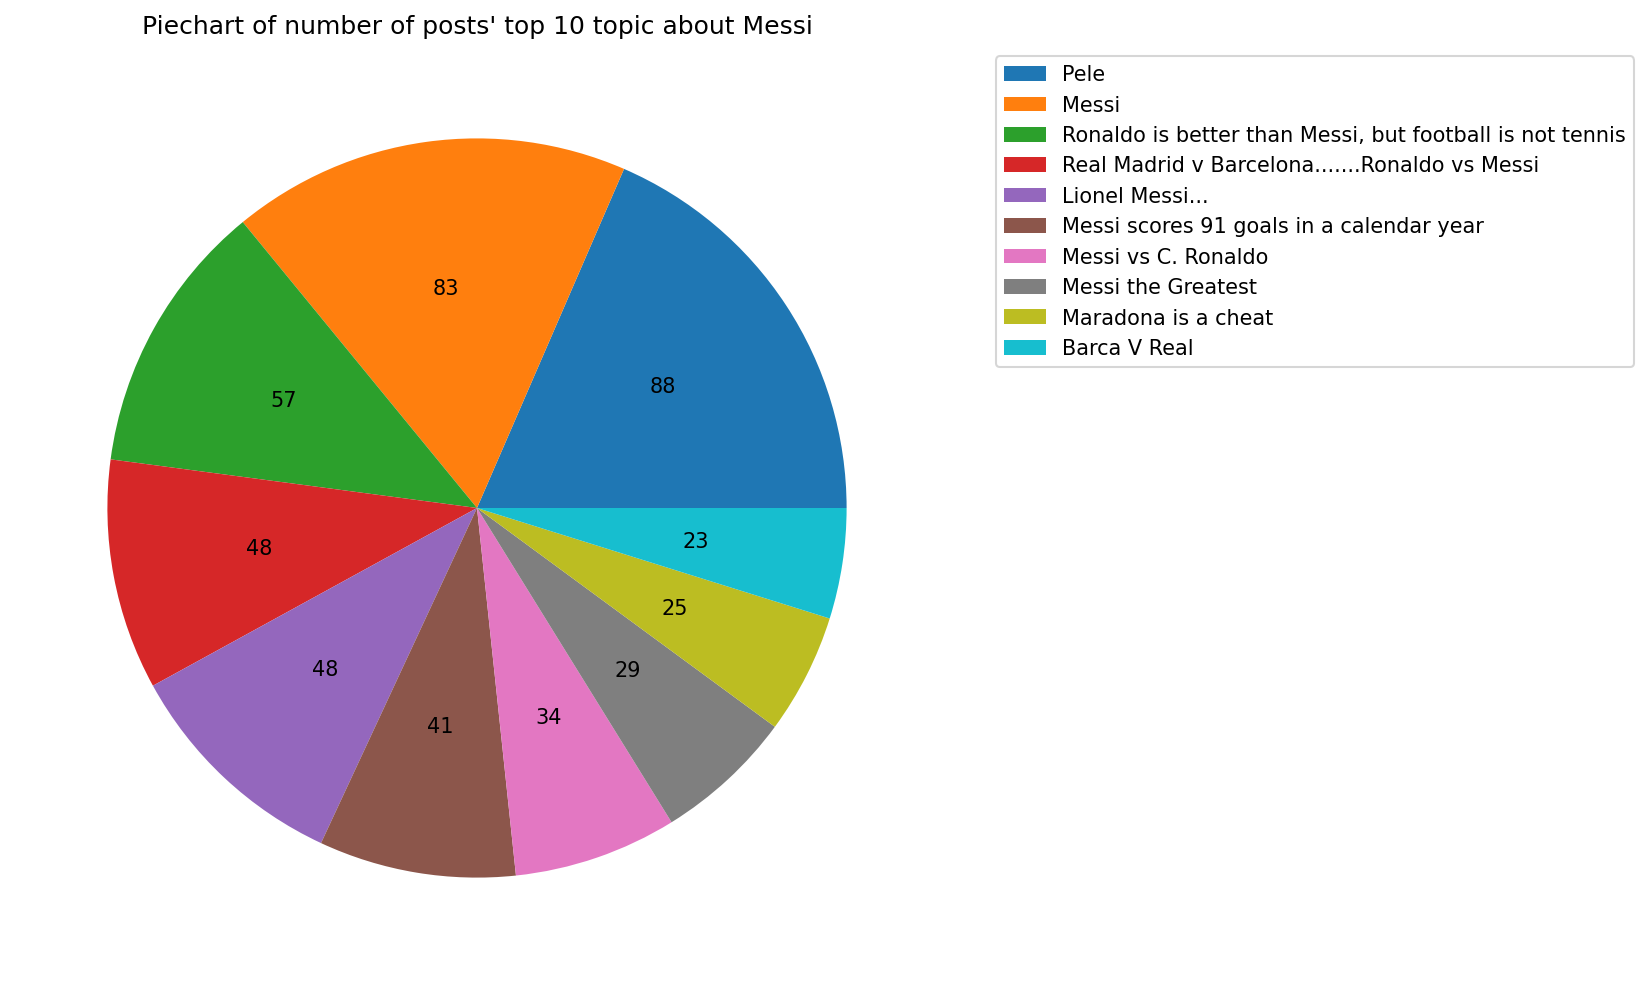

In [38]:
plt.figure(figsize=(16, 8), dpi=150) 
autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[1].head(10)['count'])/100.0)
plt.pie(topic_count_dfList[1].head(10)['count'], labels=None, autopct=autopct)
plt.legend(labels=topic_count_dfList[1].head(10)['topic'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of number of posts' top 10 topic about Messi")
# plt.show()
plt.savefig("top10Topic_messi_graph.png")

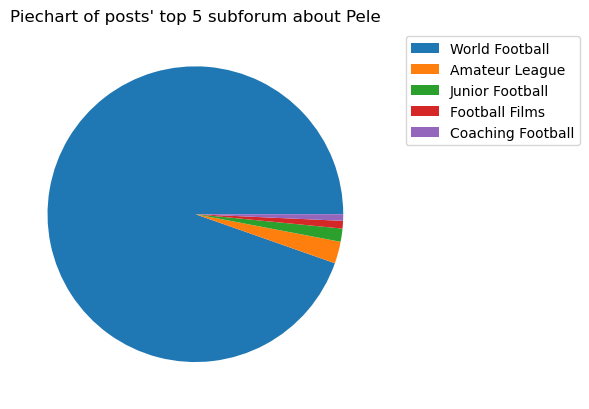

In [39]:
plt.pie(subforum_count_dfList[2].head(5)['count'], labels=None)
plt.legend(labels=subforum_count_dfList[2].head(5)['subforum'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of posts' top 5 subforum about Pele")
plt.show()

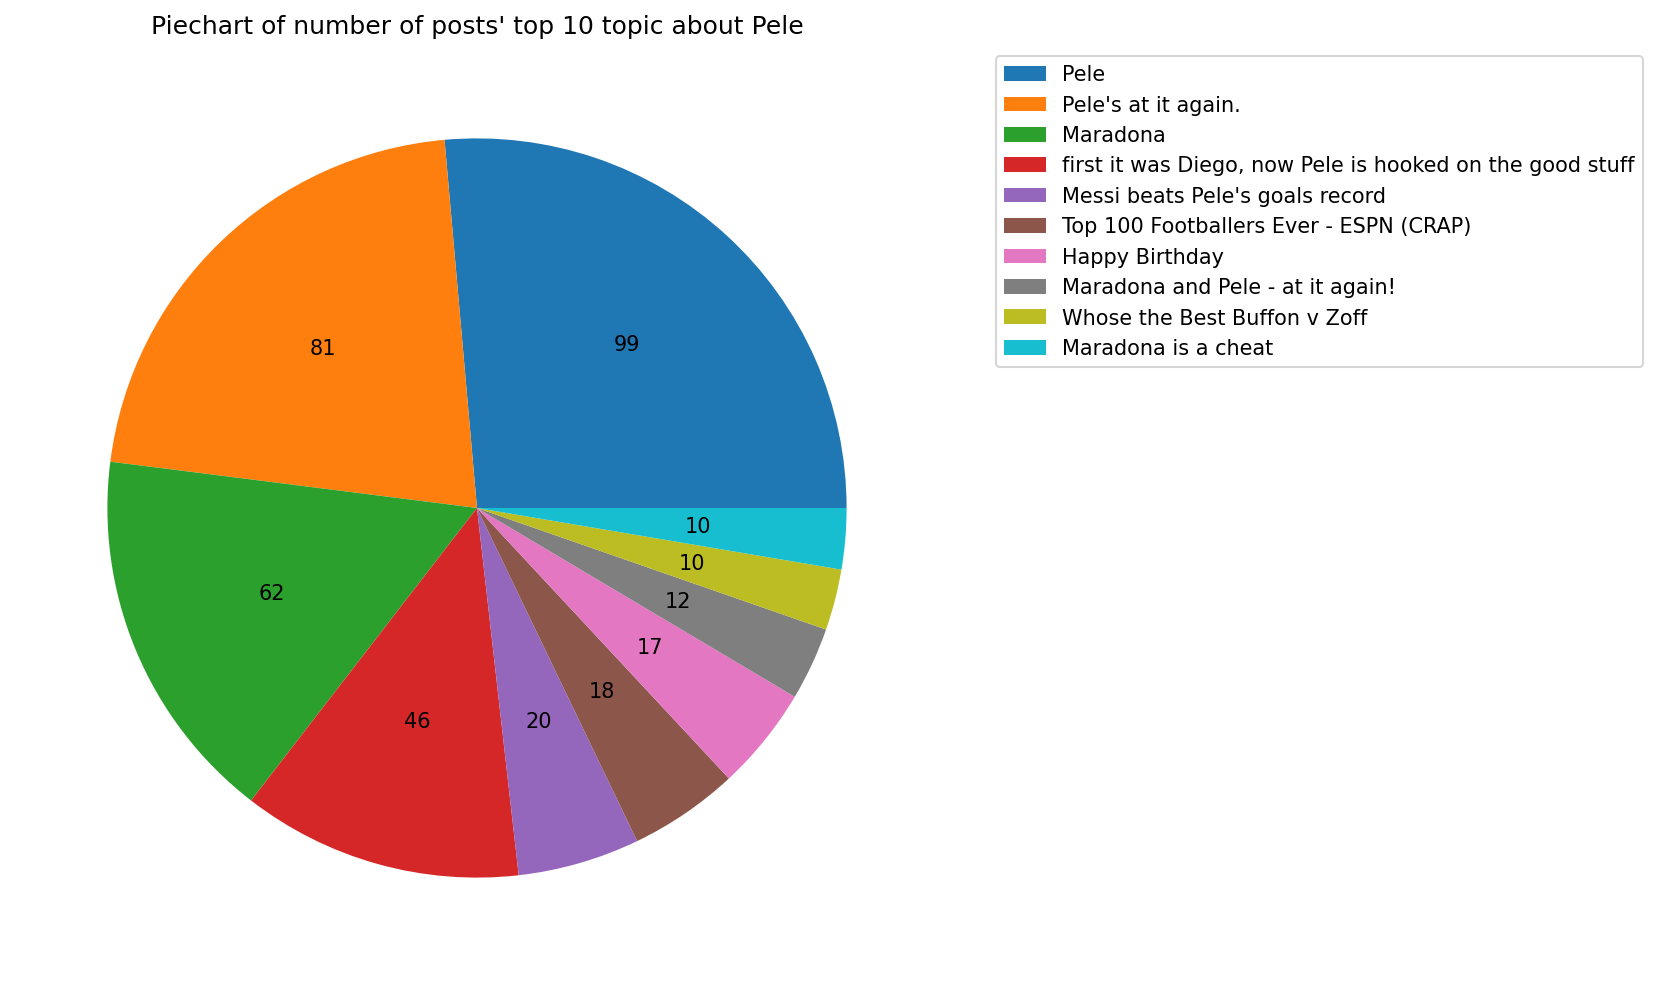

In [40]:
plt.figure(figsize=(16, 8), dpi=150) 
autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[2].head(10)['count'])/100.0)
plt.pie(topic_count_dfList[2].head(10)['count'], labels=None, autopct=autopct)
plt.legend(labels=topic_count_dfList[2].head(10)['topic'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of number of posts' top 10 topic about Pele")
# plt.show()
plt.savefig("top10Topic_pele_graph.png")

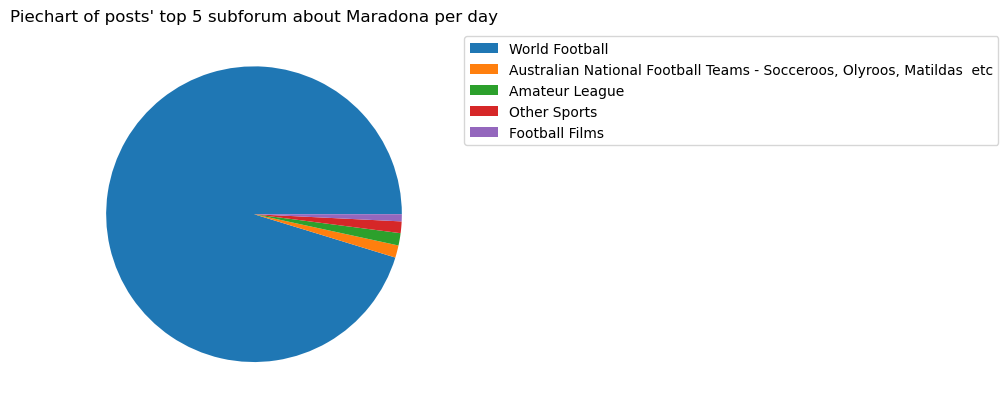

In [41]:
plt.pie(subforum_count_dfList[3].head(5)['count'], labels=None)
plt.legend(labels=subforum_count_dfList[3].head(5)['subforum'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of posts' top 5 subforum about Maradona per day")
plt.show()

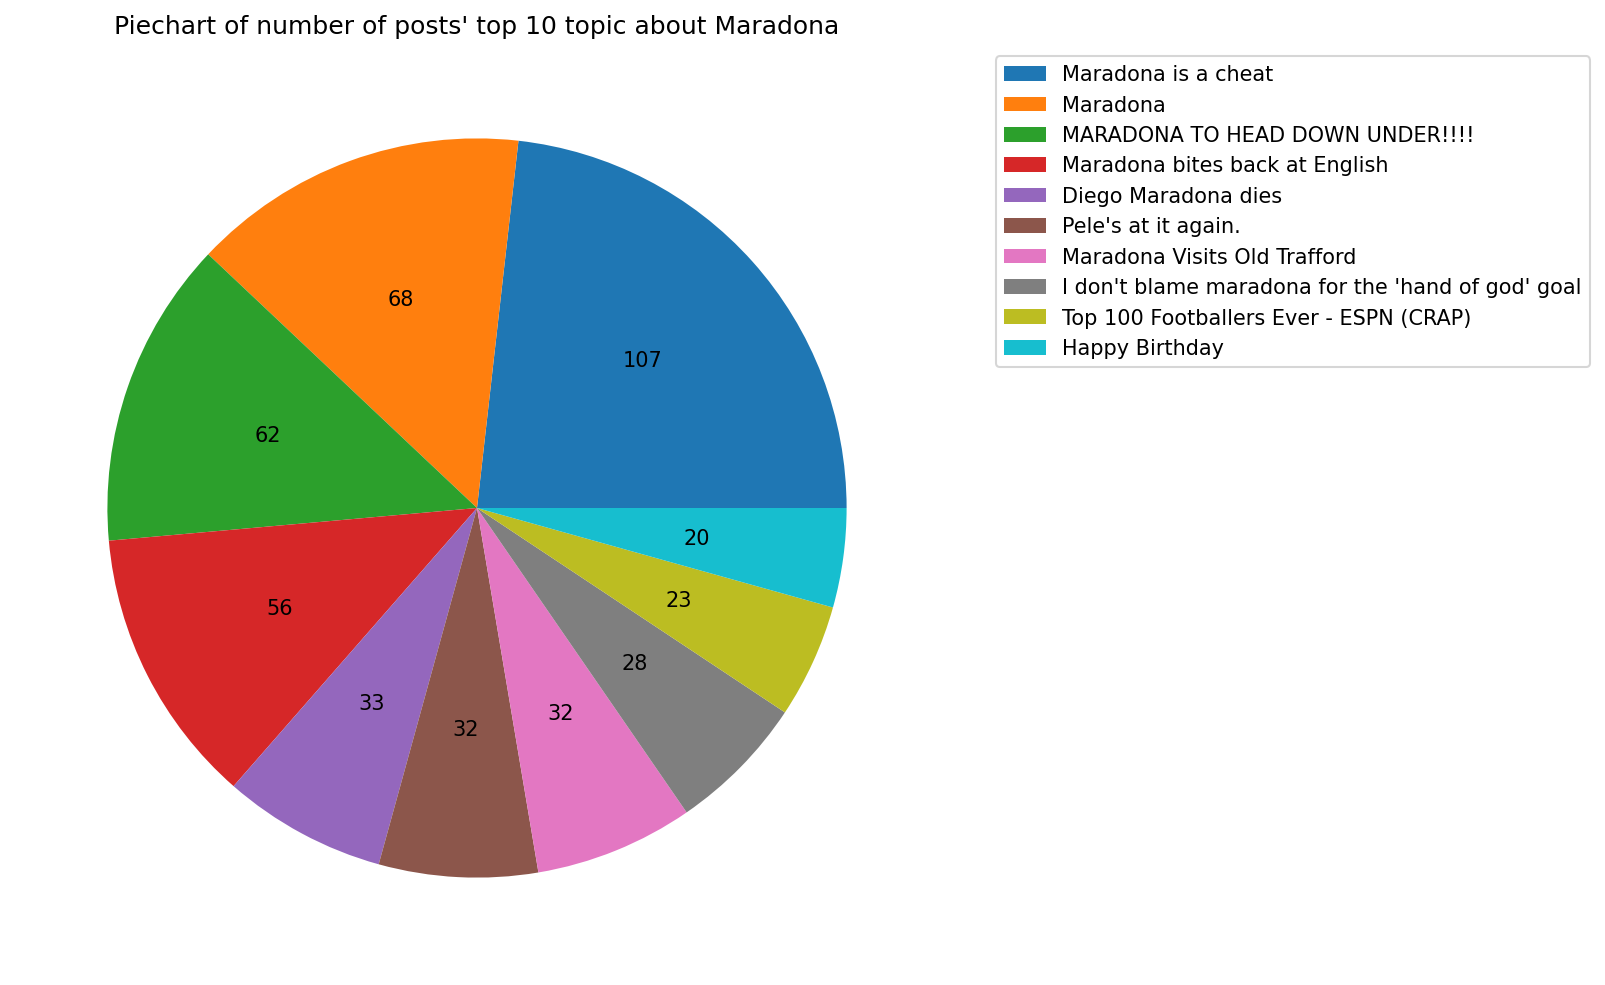

In [42]:
plt.figure(figsize=(16, 8), dpi=150) 
autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[3].head(10)['count'])/100.0)
plt.pie(topic_count_dfList[3].head(10)['count'], labels=None, autopct=autopct)
plt.legend(labels=topic_count_dfList[3].head(10)['topic'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of number of posts' top 10 topic about Maradona")
# plt.show()
plt.savefig("top10Topic_maradona_graph.png")

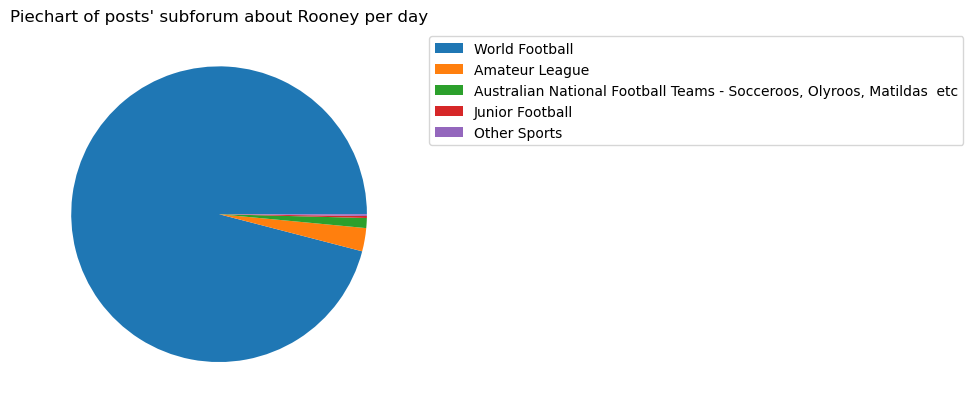

In [43]:
plt.pie(subforum_count_dfList[4].head(5)['count'], labels=None)
plt.legend(labels=subforum_count_dfList[4].head(5)['subforum'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of posts' subforum about Rooney per day")
plt.show()

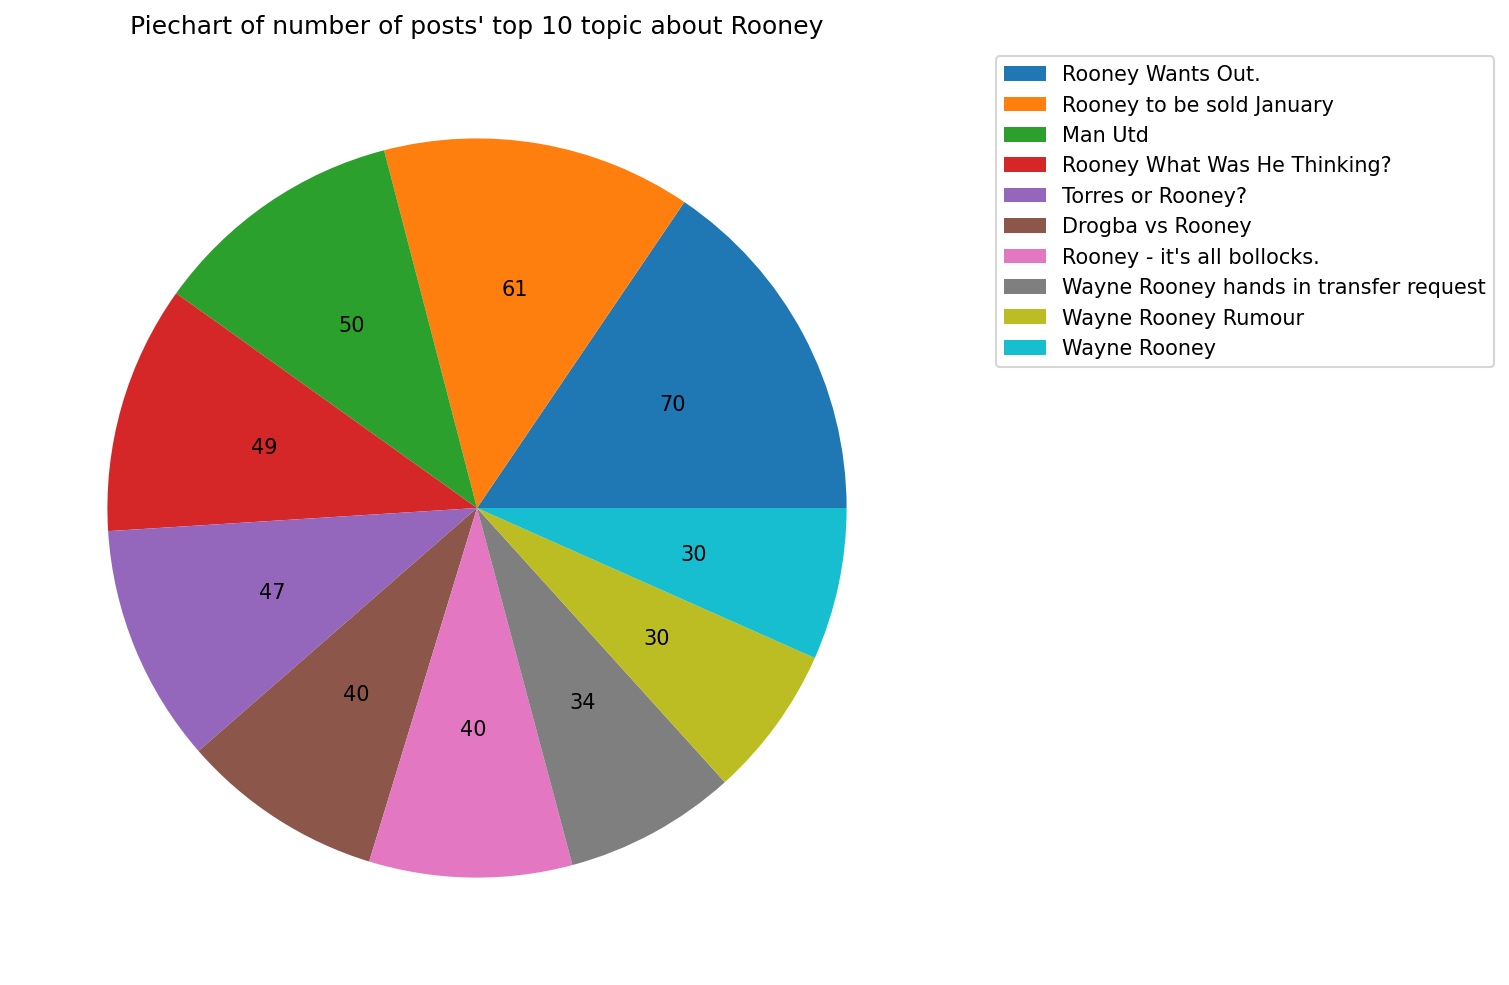

In [44]:
plt.figure(figsize=(16, 8), dpi=150) 
autopct = lambda x: "%d" % round(x*sum(topic_count_dfList[4].head(10)['count'])/100.0)
plt.pie(topic_count_dfList[4].head(10)['count'], labels=None, autopct=autopct)
plt.legend(labels=topic_count_dfList[4].head(10)['topic'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Piechart of number of posts' top 10 topic about Rooney")
# plt.show()
plt.savefig("top10Topic_rooney_graph.png")

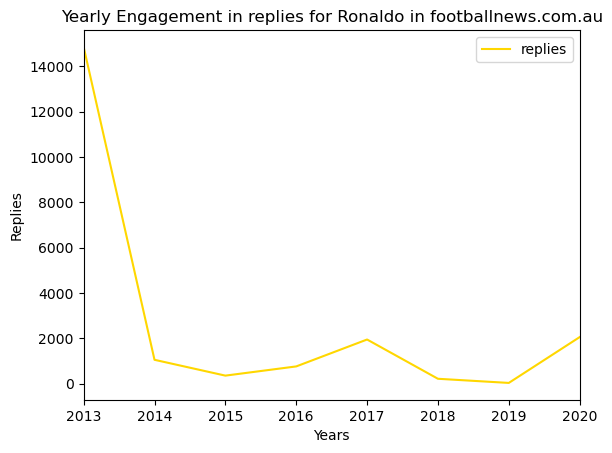

In [120]:
new_series_list_ronaldo = repl_count_dfList_ronaldo.resample('1Y').sum()
new_series_list_ronaldo.plot(label='Ronaldo', color='gold')
plt.title("Yearly Engagement in replies for Ronaldo in footballnews.com.au")
    
plt.xlabel('Years') 
plt.ylabel('Replies')
plt.savefig('yearlyEngagement_ronaldo2013.png')

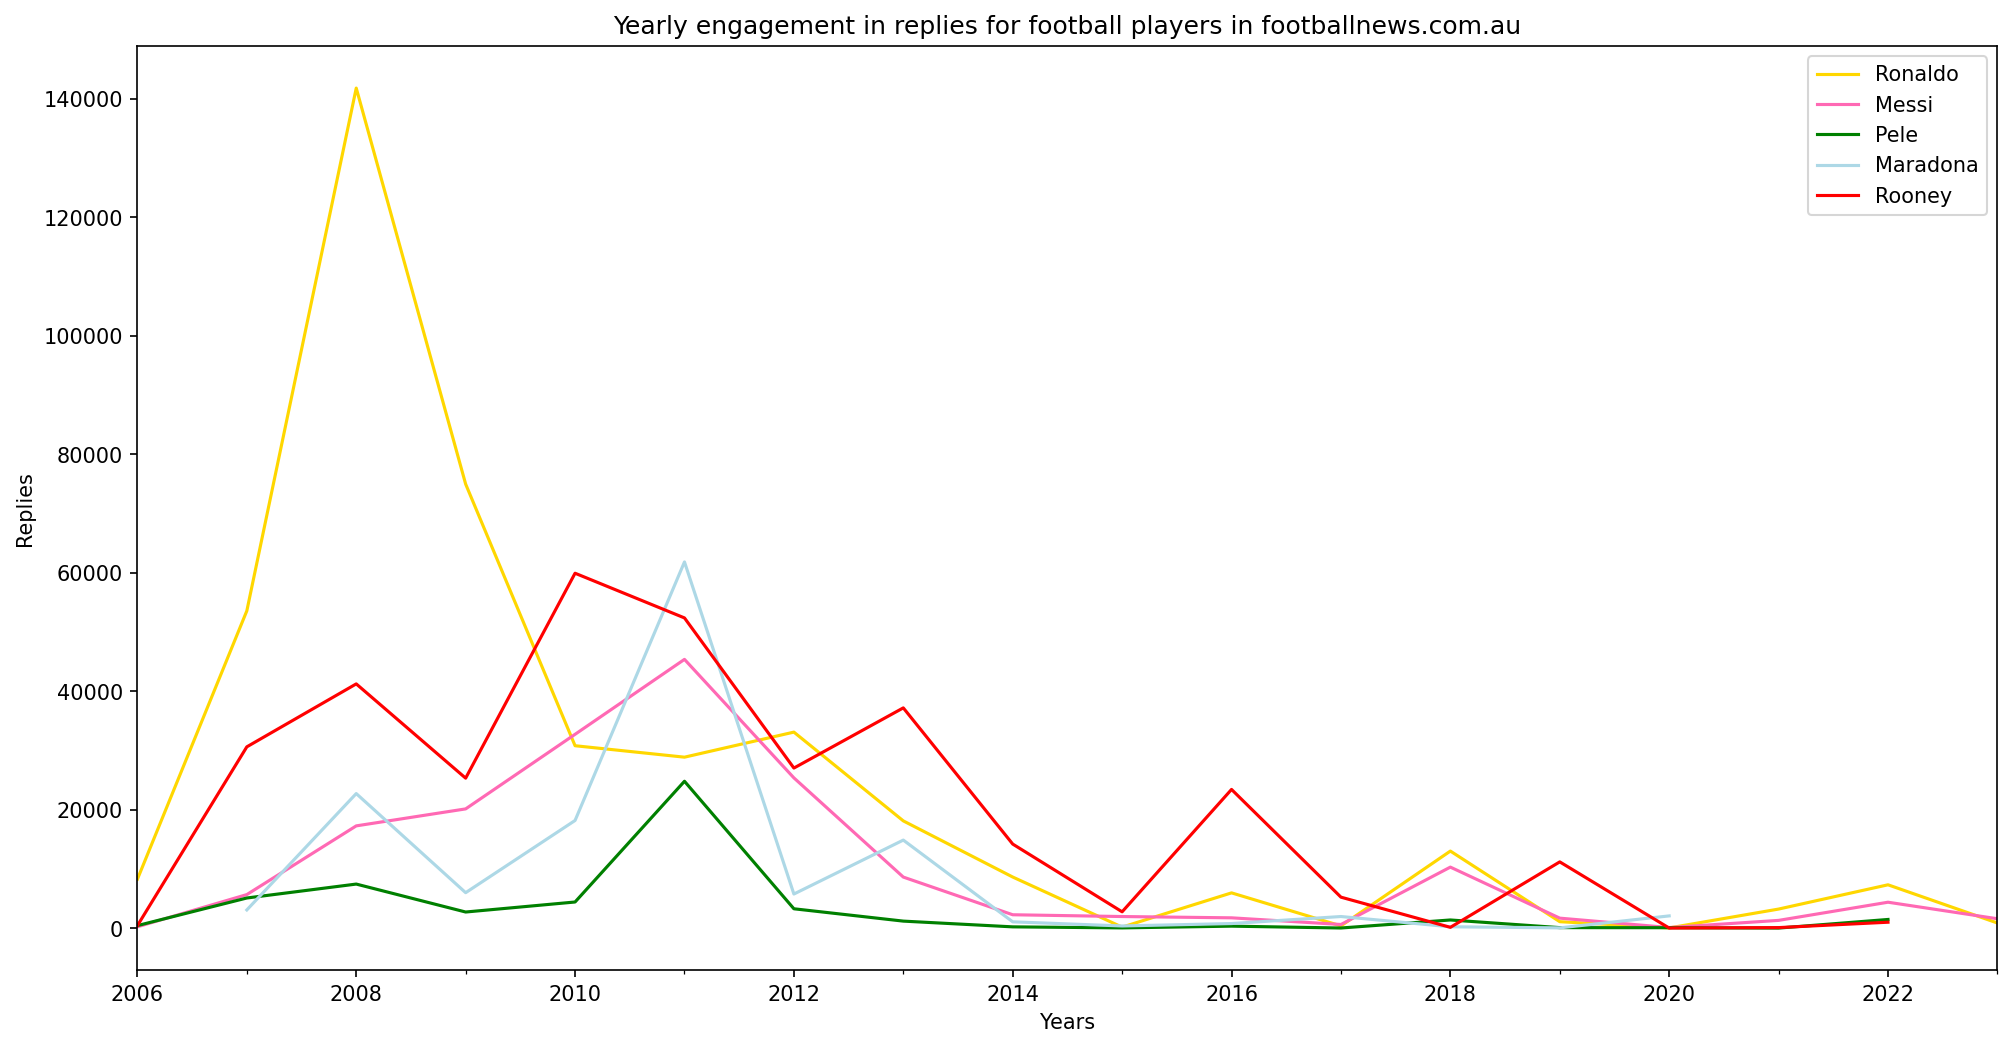

In [45]:
comparePlotTS(playerNames, repl_count_dfList, '1Y', 'replies')
plt.savefig('yearlyEngagement_repl_graph.png')

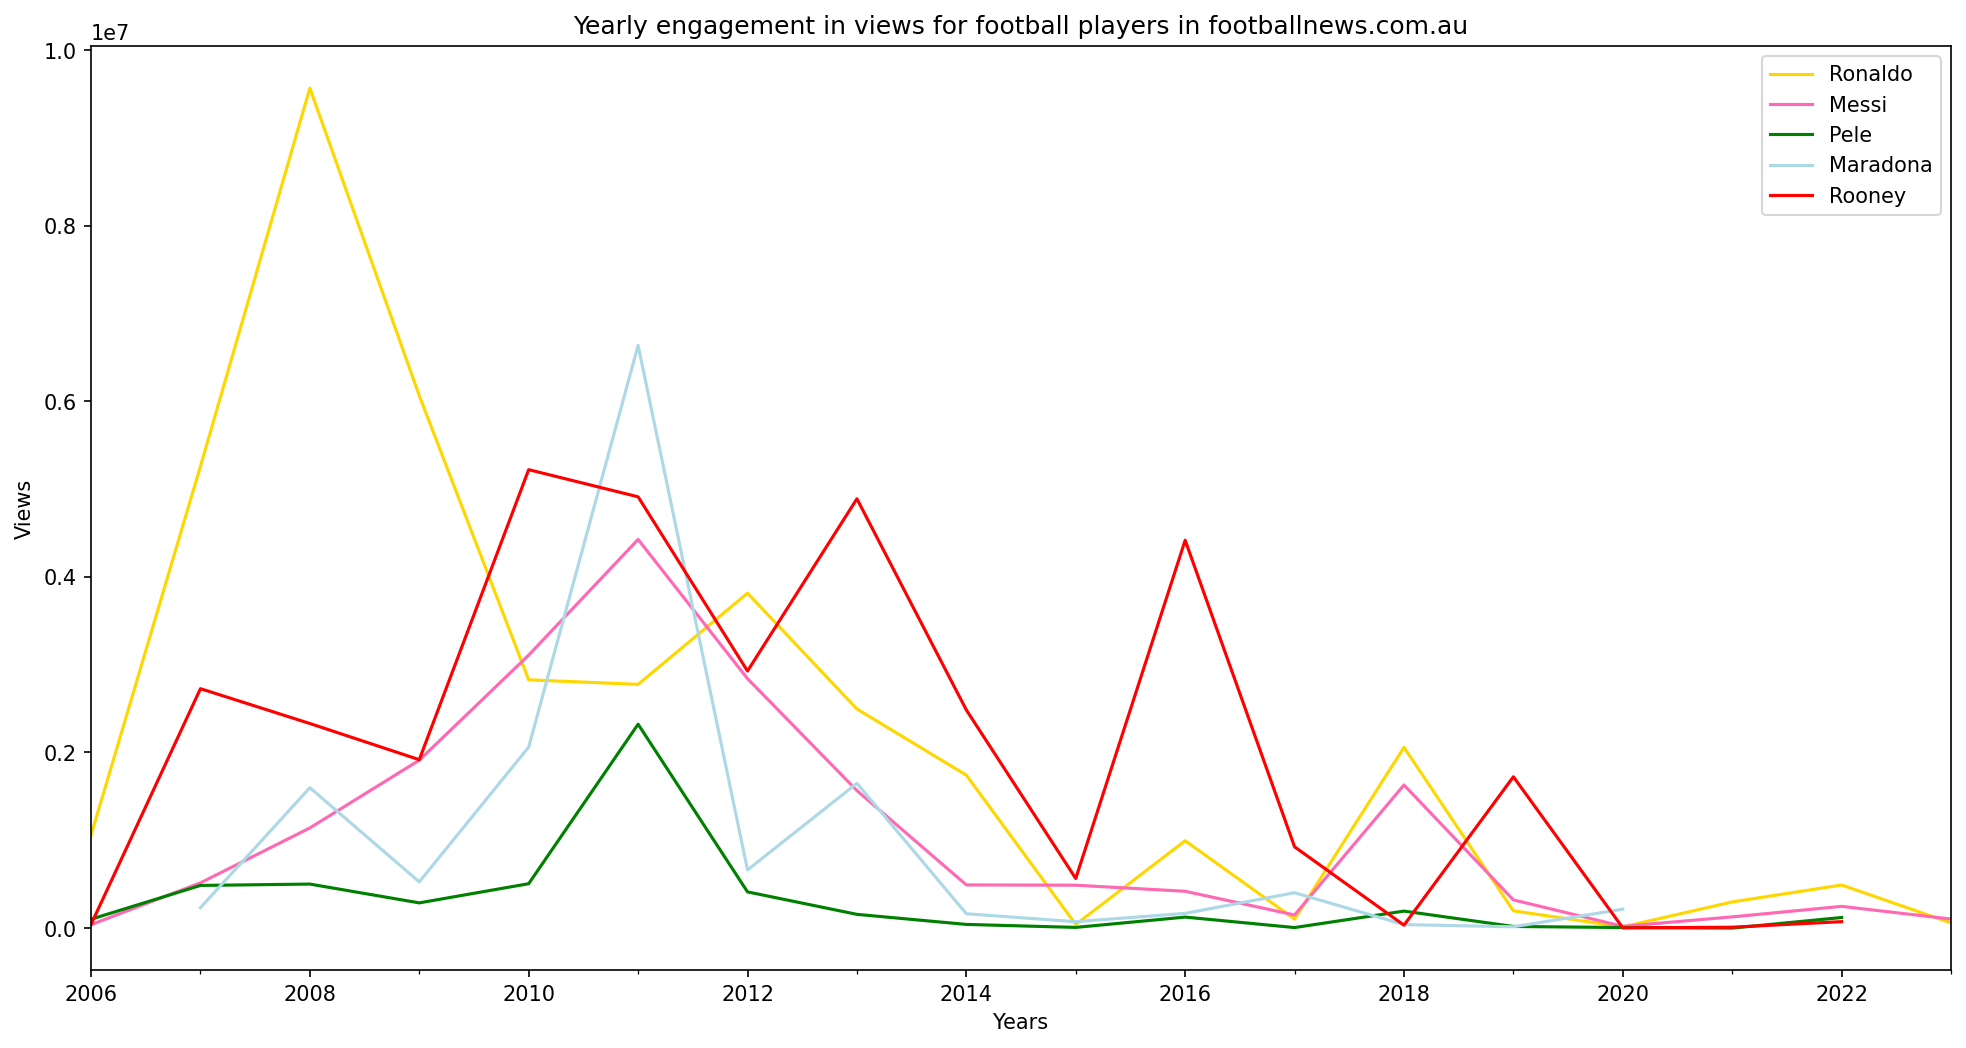

In [46]:
comparePlotTS(playerNames, view_count_dfList, '1Y', 'views')
plt.savefig('yearlyEngagement_view_graph.png')

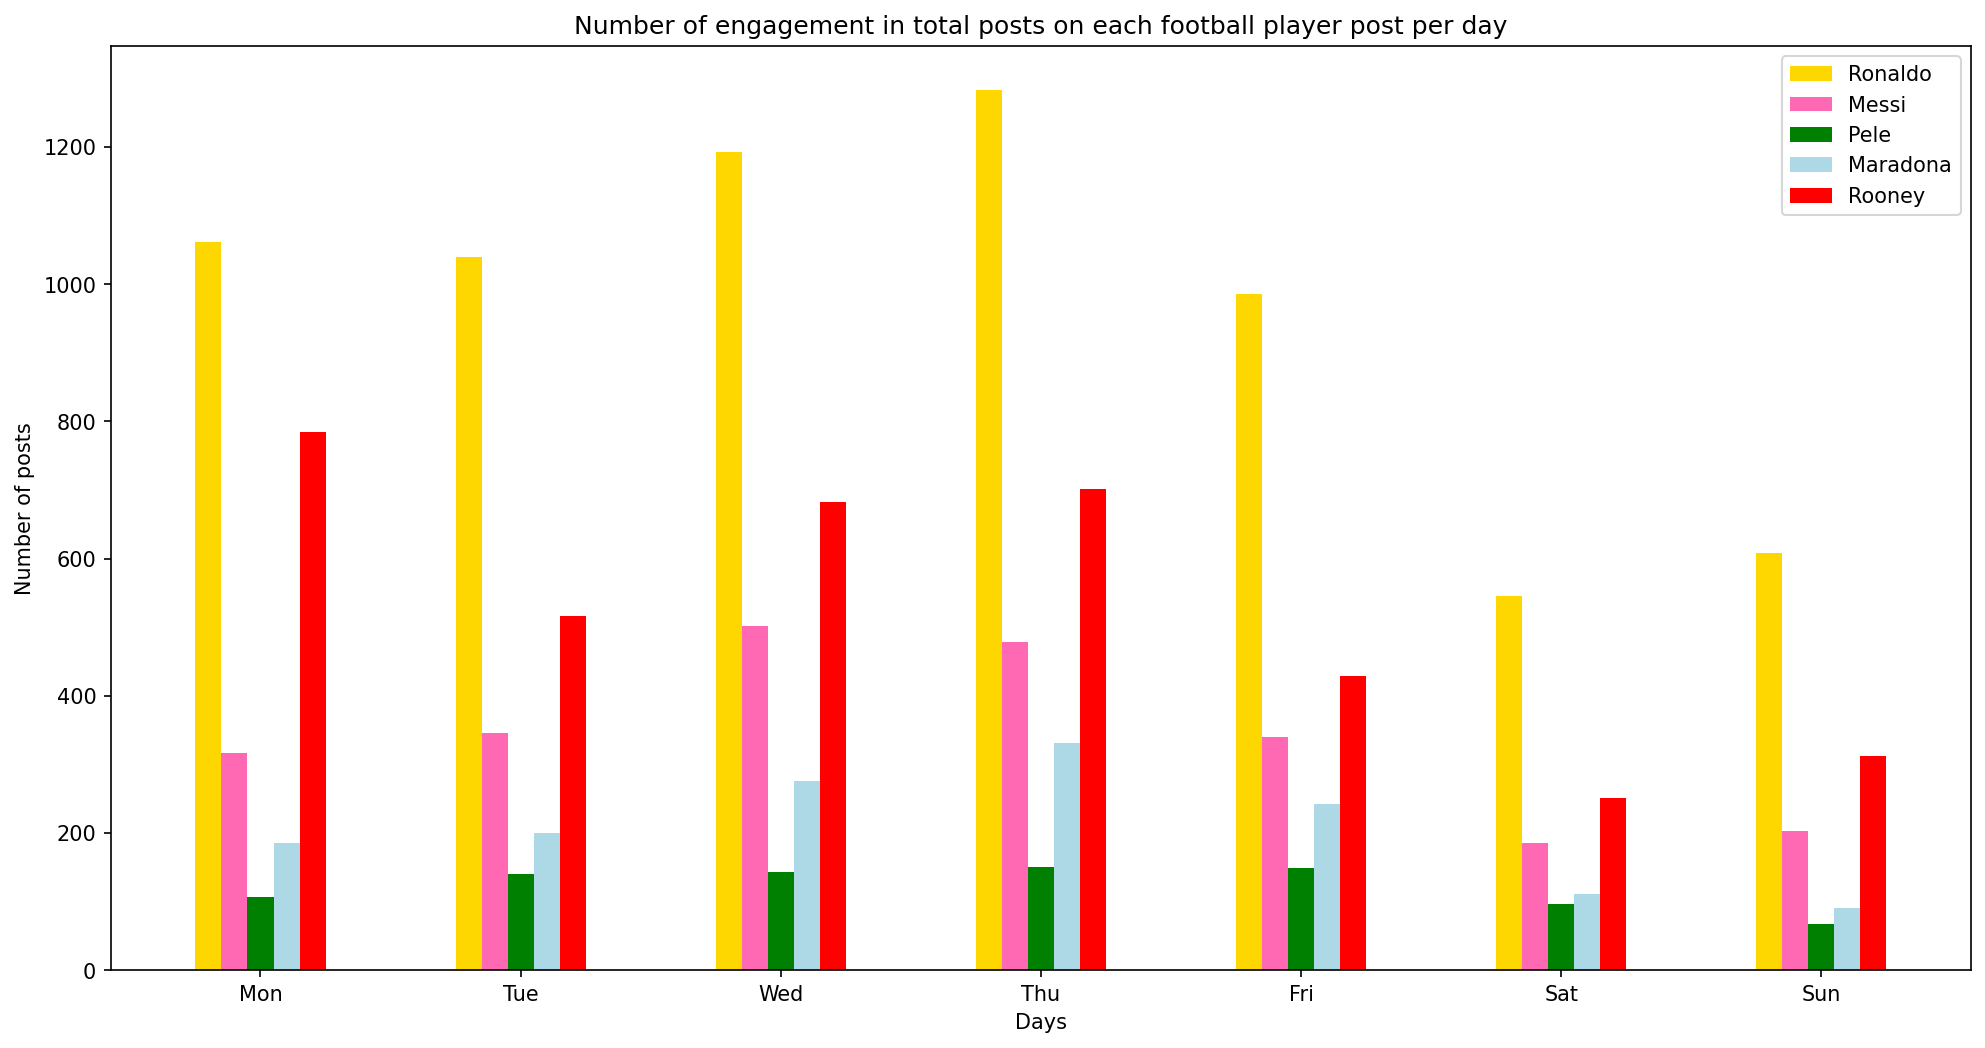

In [49]:
plt.figure(figsize=(16, 8), dpi=150) 
X = np.arange(7)
offset = 0.1

plt.bar(X - 0.2, day_postCount_dfList[0]['count'], color = colorList[0], width = 0.1, label = playerNames[0])
plt.bar(X - 0.1, day_postCount_dfList[1]['count'], color = colorList[1], width = 0.1, label = playerNames[1])
plt.bar(X, day_postCount_dfList[2]['count'], color = colorList[2], width = 0.1, label = playerNames[2])
plt.bar(X + 0.1, day_postCount_dfList[3]['count'], color = colorList[3], width = 0.1, label = playerNames[3])
plt.bar(X + 0.2, day_postCount_dfList[4]['count'], color = colorList[4], width = 0.1, label = playerNames[4])

plt.xticks(X, day_postCount_dfList[0]['dayType']) 
plt.xlabel("Days") 
plt.ylabel("Number of posts") 
plt.title("Number of engagement in total posts on each football player post per day") 
plt.legend()
plt.show()

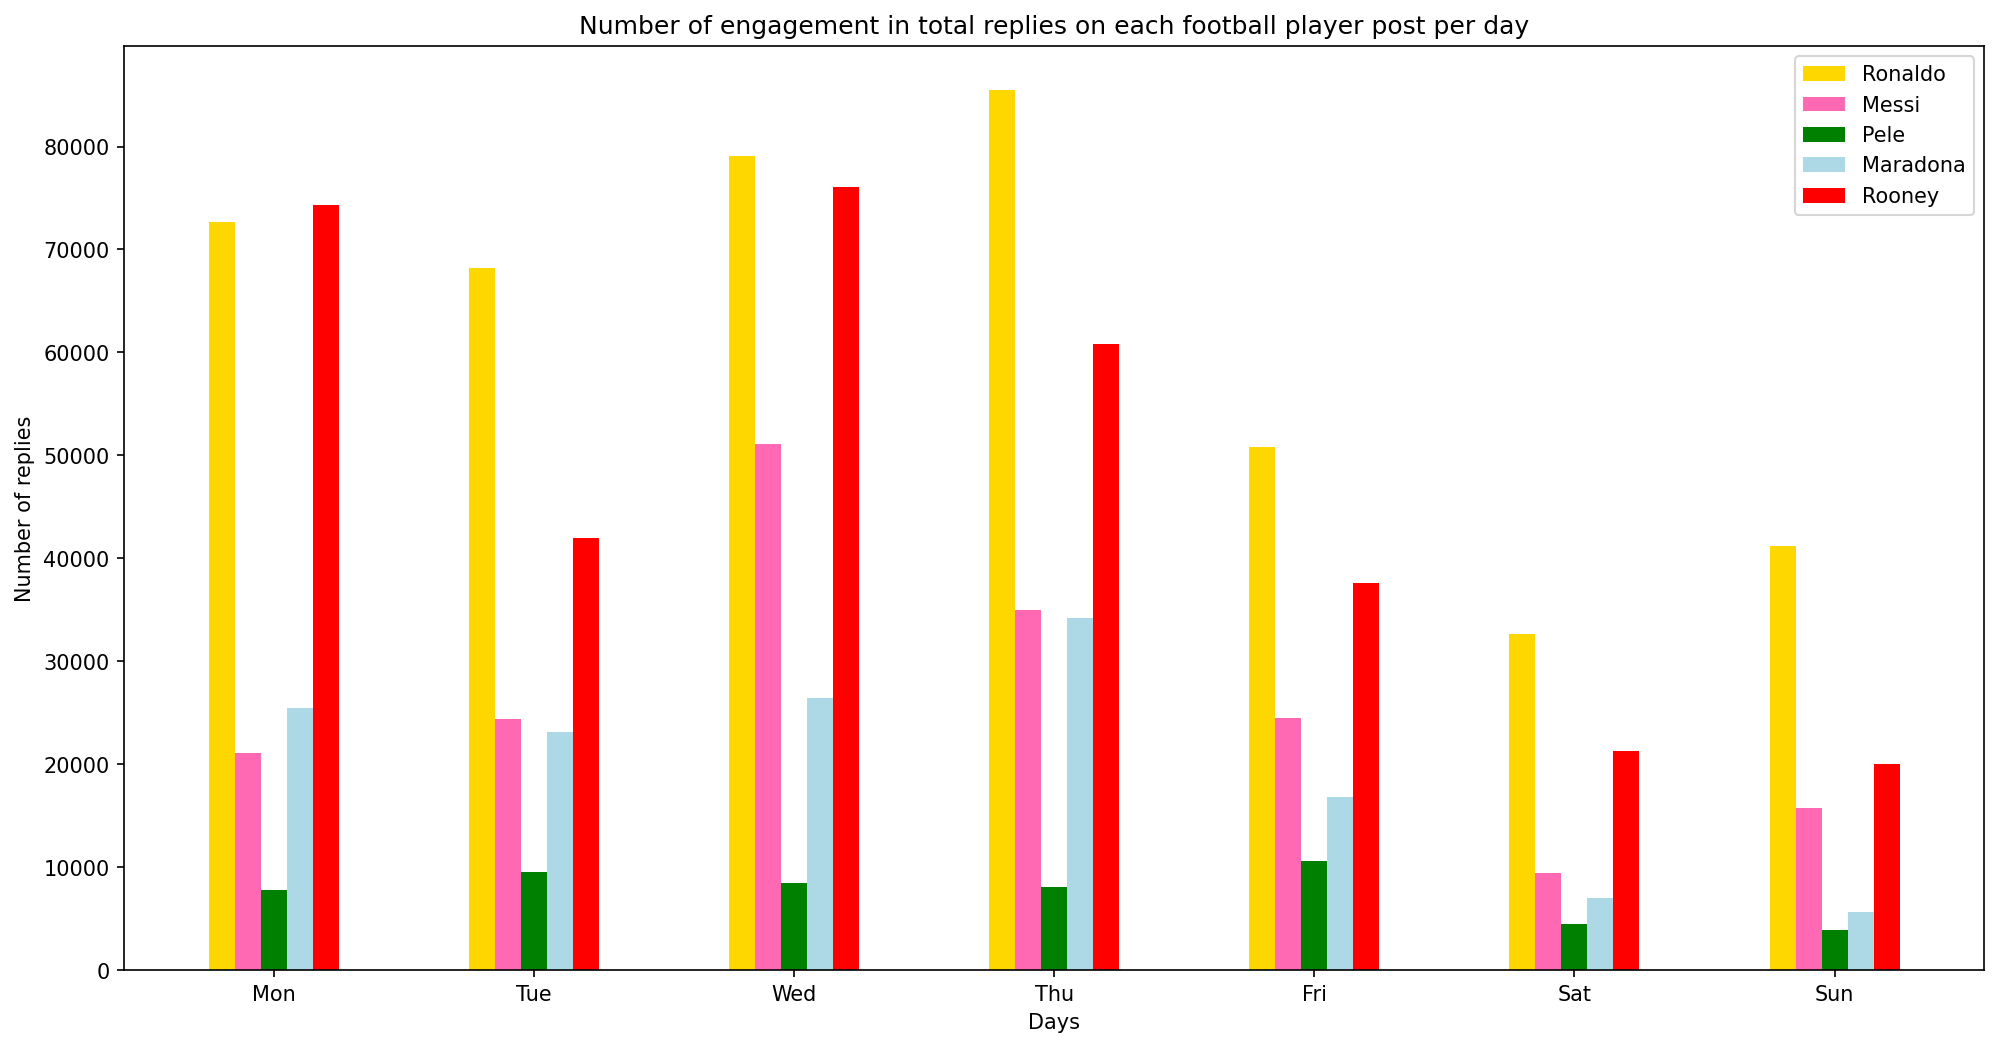

In [50]:
plt.figure(figsize=(16, 8), dpi=150) 
X = np.arange(7)
offset = 0.1

plt.bar(X - 0.2, day_postReplies_dfList[0]['replies'], color = colorList[0], width = 0.1, label = playerNames[0])
plt.bar(X - 0.1, day_postReplies_dfList[1]['replies'], color = colorList[1], width = 0.1, label = playerNames[1])
plt.bar(X, day_postReplies_dfList[2]['replies'], color = colorList[2], width = 0.1, label = playerNames[2])
plt.bar(X + 0.1, day_postReplies_dfList[3]['replies'], color = colorList[3], width = 0.1, label = playerNames[3])
plt.bar(X + 0.2, day_postReplies_dfList[4]['replies'], color = colorList[4], width = 0.1, label = playerNames[4])

plt.xticks(X, day_postReplies_dfList[0]['dayType']) 
plt.xlabel("Days") 
plt.ylabel("Number of replies") 
plt.title("Number of engagement in total replies on each football player post per day") 
plt.legend()
plt.show()

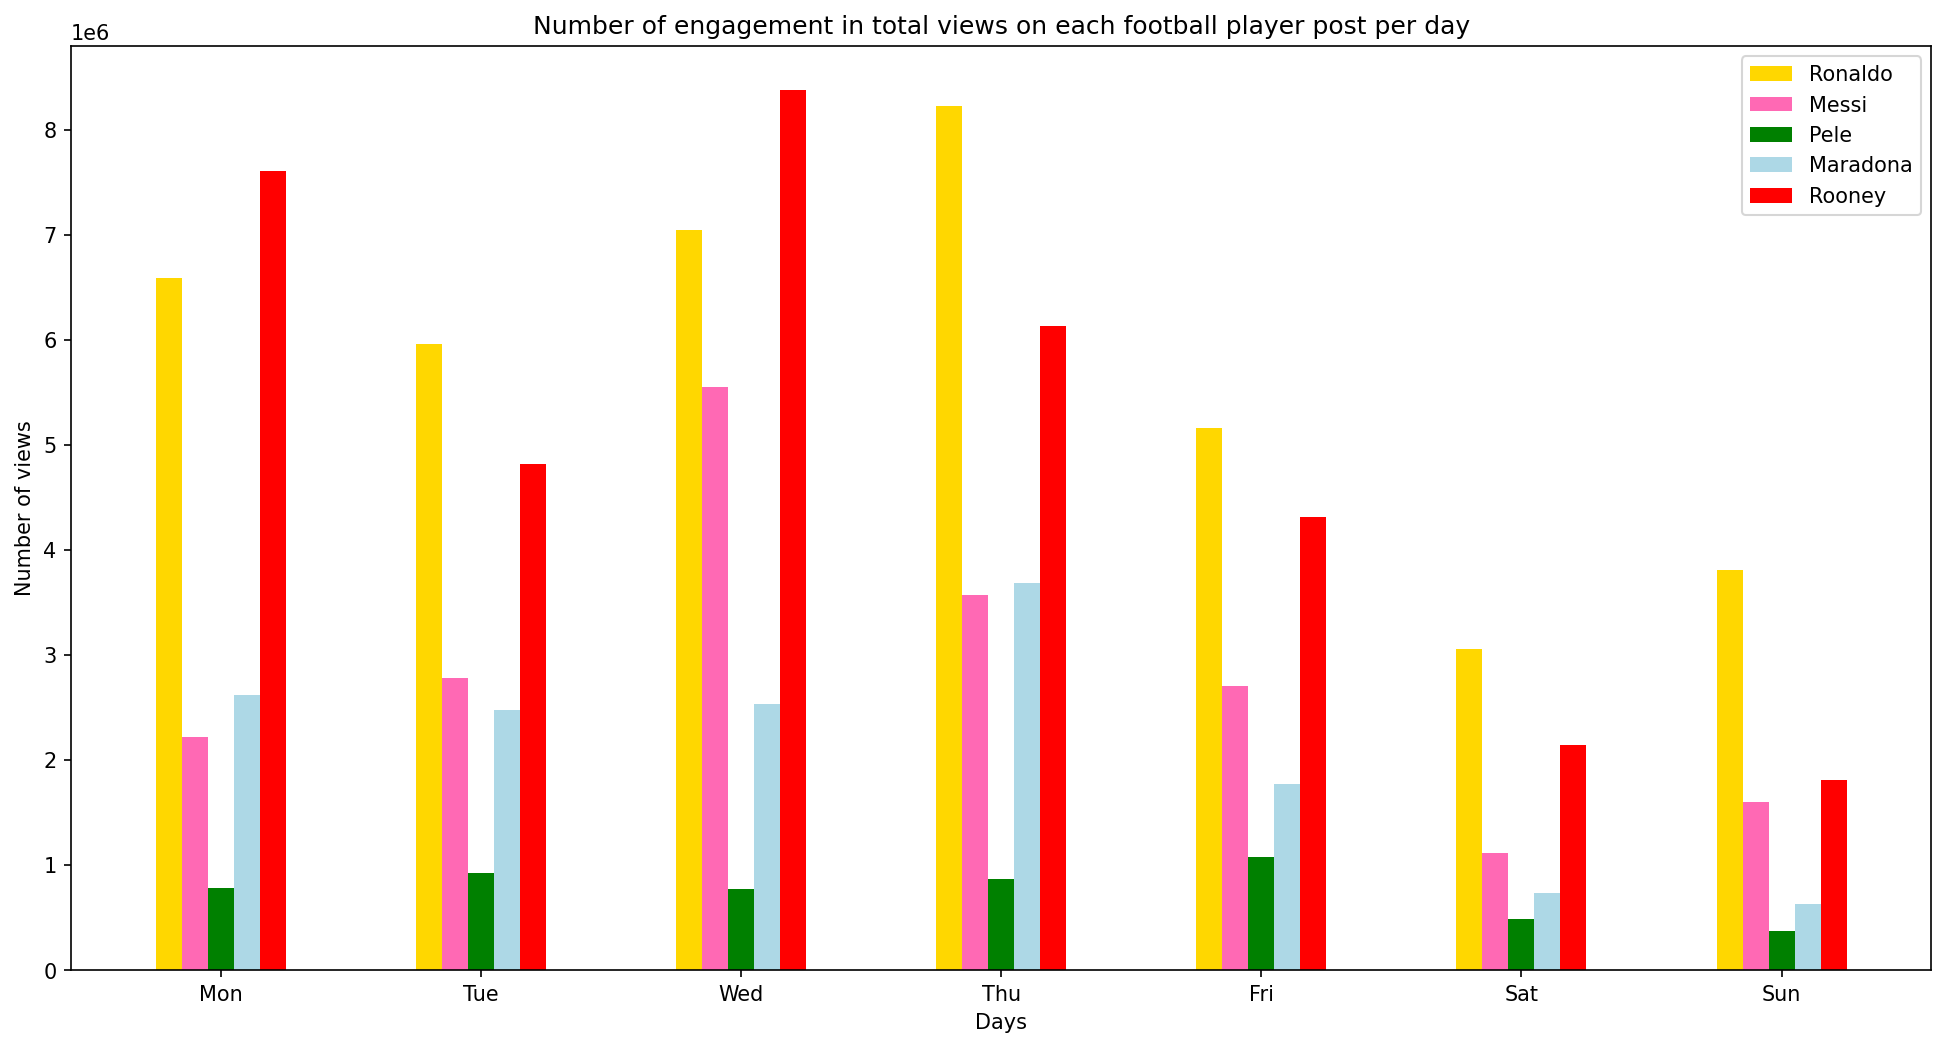

In [51]:
plt.figure(figsize=(16, 8), dpi=150) 
X = np.arange(7)
offset = 0.1

plt.bar(X - 0.2, day_postViews_dfList[0]['views'], color = colorList[0], width = 0.1, label = playerNames[0])
plt.bar(X - 0.1, day_postViews_dfList[1]['views'], color = colorList[1], width = 0.1, label = playerNames[1])
plt.bar(X, day_postViews_dfList[2]['views'], color = colorList[2], width = 0.1, label = playerNames[2])
plt.bar(X + 0.1, day_postViews_dfList[3]['views'], color = colorList[3], width = 0.1, label = playerNames[3])
plt.bar(X + 0.2, day_postViews_dfList[4]['views'], color = colorList[4], width = 0.1, label = playerNames[4])

plt.xticks(X, day_postViews_dfList[0]['dayType']) 
plt.xlabel("Days") 
plt.ylabel("Number of views") 
plt.title("Number of engagement in total views on each football player post per day") 
plt.legend()
plt.show()

In [52]:
# using regex tokenizer to be more 'precise'
reg_tokenizer = RegexpTokenizer(regexpr)

# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)
# use stopwords from nltk, a few other twitter specific terms like 'TIL' and 'AMA', and the word 'esport' specifically
lStopwords = nltk.corpus.stopwords.words('english') + lPunct
# Using the Porter stemmer
redditStemmer = nltk.stem.PorterStemmer()

In [53]:
def termFreqCountFunc(data, counter):
    for i in range(len(data)):
        text_preproc = data['text'][i]
        # tokenise, filter stopwords and get convert to lower case
        lTokens = proc_text(text=text_preproc, tokenizer=reg_tokenizer, stemmer=redditStemmer, stopwords=lStopwords)

        # update count
        counter.update(lTokens)

In [54]:
def termFreqTabulateFunc(tabulate_list, count_list):
    for i in range(num_freq_term+1):
        tabulate_list.append(list())
        if i == 0:
            tabulate_list[i] = playerNames
        else:
            for j in range(len(playerNames)):
                currStr = ""
                currWord = count_list[j].most_common(num_freq_term)[i-1][0]
                currFreq = str(count_list[j].most_common(num_freq_term)[i-1][1])
                currStr += currWord + ": " + currFreq
                tabulate_list[i].append(currStr)

In [55]:
term_freq_count_text_list = []
for i in range(len(playerNames)):
    term_freq_count_text_list.append(Counter())
    termFreqCountFunc(dataList_clean[i], term_freq_count_text_list[i])

term_freq_tabulate_list = []
termFreqTabulateFunc(term_freq_tabulate_list, term_freq_count_text_list)

In [56]:
# print(tabulate(term_freq_tabulate_list, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(term_freq_tabulate_list, headers='firstrow'))

Ronaldo         Messi           Pele           Maradona        Rooney
--------------  --------------  -------------  --------------  ------------
ronaldo: 5096   messi: 1728     pele: 598      maradona: 1033  rooney: 2949
player: 1510    player: 624     maradona: 248  wa: 436         wa: 750
wa: 1295        ronaldo: 465    wa: 246        hi: 318         player: 734
hi: 1175        wa: 430         player: 212    player: 301     hi: 629
thi: 1105       play: 419       hi: 169        diego: 249      play: 591
ha: 992         world: 381      best: 169      world: 206      ronaldo: 562
play: 929       hi: 354         world: 149     play: 199       thi: 559
like: 921       best: 351       play: 147      ha: 198         wayn: 495
would: 795      thi: 350        ha: 125        thi: 194        like: 491
team: 768       ha: 330         like: 121      goal: 183       unit: 480
cristiano: 756  like: 326       game: 114      like: 182       ha: 479
game: 739       would: 324      would: 114     wou

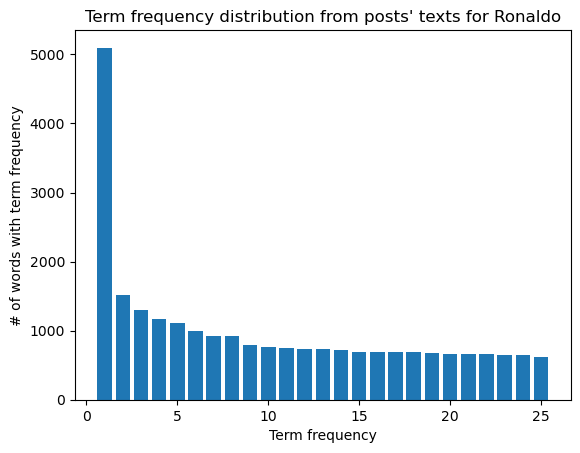

In [57]:
# construct the x and y values
y = [count for tag, count in term_freq_count_text_list[0].most_common(num_freq_term)]
x = range(1, len(y) + 1)

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Term frequency distribution from posts' texts for Ronaldo")
plt.ylabel('# of words with term frequency')
plt.xlabel('Term frequency')
plt.show()

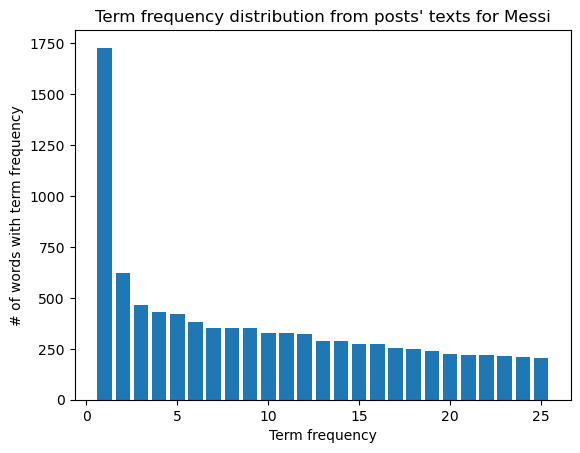

In [58]:
# construct the x and y values
y = [count for tag, count in term_freq_count_text_list[1].most_common(num_freq_term)]
x = range(1, len(y) + 1)

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Term frequency distribution from posts' texts for Messi")
plt.ylabel('# of words with term frequency')
plt.xlabel('Term frequency')
plt.show()

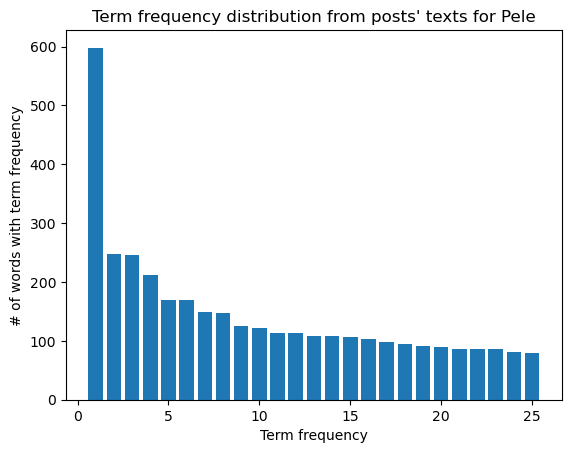

In [59]:
# construct the x and y values
y = [count for tag, count in term_freq_count_text_list[2].most_common(num_freq_term)]
x = range(1, len(y) + 1)

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Term frequency distribution from posts' texts for Pele")
plt.ylabel('# of words with term frequency')
plt.xlabel('Term frequency')
plt.show()

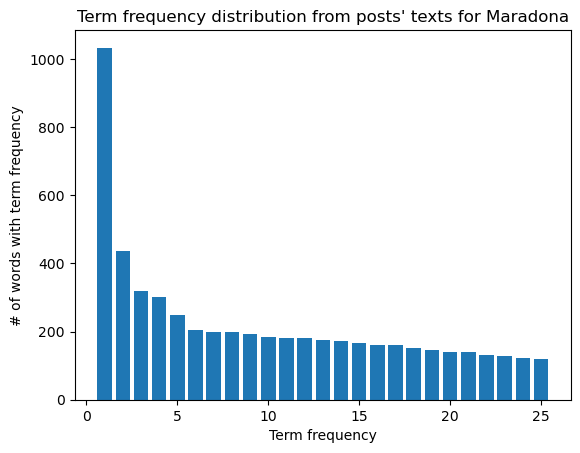

<Figure size 640x480 with 0 Axes>

In [60]:
# construct the x and y values
y = [count for tag, count in term_freq_count_text_list[3].most_common(num_freq_term)]
x = range(1, len(y) + 1)

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Term frequency distribution from posts' texts for Maradona")
plt.ylabel('# of words with term frequency')
plt.xlabel('Term frequency')
plt.show()
plt.savefig('termFreq_Maradona_graph.png')

Sentiment Analysis for 'Ronaldo' and 'Messi' in Australia

In [61]:
posWordFile = 'positive-words.txt' # input file of set of postive words
negWordFile = 'negative-words.txt' # input file of set of negative words

flagPrint = False # flag to determine whether to print out tweets and their sentiment

regexpr = r'\w+' # Regular Expression for tokenizer

In [62]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.
    
    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [63]:
def vaderSentimentAnalysis(data, bPrint, tweetProcessor):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    
    for i in range(len(data)):
        post_text = data['text'][i]
        post_date = data['datetime'][i]

        # pre-process the post text
        lTokens = redditProcessor.process(post_text)

        # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
        # see workshop sheet for what dSentimentScores holds
        dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

        # save the date and sentiment of each post (used for time series)
        lSentiment.append([pd.to_datetime(post_date, unit='s'), dSentimentScores['compound']])

        # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
        # of positive and negative words, we cannot use colorama to label each token
        if bPrint:
            vaderPrintTokens(lTokens, dSentimentScores)
                    
                    
    return lSentiment

In [64]:
def vaderSentiAnalysFunc(data, colName, bPrint, tweetProcessor):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    
    for i in range(len(data)):
        post_text = data[colName][i]
        post_date = data['datetime'][i]

        # pre-process the post text
        lTokens = redditProcessor.process(post_text)

        # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
        # see workshop sheet for what dSentimentScores holds
        dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

        # save the date and sentiment of each post (used for time series)
        lSentiment.append([pd.to_datetime(post_date, unit='s'), dSentimentScores['compound']])

        # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
        # of positive and negative words, we cannot use colorama to label each token
        if bPrint:
            vaderPrintTokens(lTokens, dSentimentScores)
                    
                    
    return lSentiment

In [85]:
# construct the reddit pro-processing object
# use regex tokenizer
reg_tokenizer = RegexpTokenizer(regexpr)
lPunct = list(string.punctuation)
# standard 'English' stopwords
lStopwords = stopwords.words('english') + lPunct

# call the RedditProcessing python script
redditProcessor = RedditProcessing.RedditProcessing(reg_tokenizer, lStopwords)


# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

In [86]:
text_l_senti_list = []
for i in range(len(playerNames)):
    text_l_senti_list.append(list())
    text_l_senti_list[i] = vaderSentimentAnalysis(dataList_clean[i], flagPrint, redditProcessor)

In [88]:
text_l_senti_list_new = []
for i in range(len(playerNames)):
    text_l_senti_list_new.append(list())
    text_l_senti_list_new[i] = vaderSentiAnalysFunc(dataList_clean[i], 'text', flagPrint, redditProcessor)

topic_l_senti_list_new = []
for i in range(len(playerNames)):
    topic_l_senti_list_new.append(list())
    topic_l_senti_list_new[i] = vaderSentiAnalysFunc(dataList_clean[i], 'topic', flagPrint, redditProcessor)

In [115]:
text_l_senti_ronaldo = vaderSentiAnalysFunc(dataList_clean_ronaldo, 'text', flagPrint, redditProcessor)
topic_l_senti_ronaldo = vaderSentiAnalysFunc(dataList_clean_ronaldo, 'topic', flagPrint, redditProcessor)

In [89]:
def sentiTS(text_senti):
    # we are using pandas for this, but first we need to get it into a pandas data frame structure
    text_senti_series = pd.DataFrame(text_senti, columns=['date', 'sentiment'])
    # tell pandas that the date column is the one we use for indexing (or x-axis)
    text_senti_series.set_index('date', inplace=True)
    # pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
    # column to floats
    text_senti_series[['sentiment']] = text_senti_series[['sentiment']].apply(pd.to_numeric)
    return text_senti_series

In [117]:
text_senti_series_list = []
for i in range(len(playerNames)):
    text_senti_series_list.append(sentiTS(text_l_senti_list[i]))

In [118]:
topic_senti_series_list = []
for i in range(len(playerNames)):
    topic_senti_series_list.append(sentiTS(topic_l_senti_list_new[i]))

In [119]:
text_senti_series_ronaldo = sentiTS(text_l_senti_ronaldo)
topic_senti_series_ronaldo = sentiTS(topic_l_senti_ronaldo)

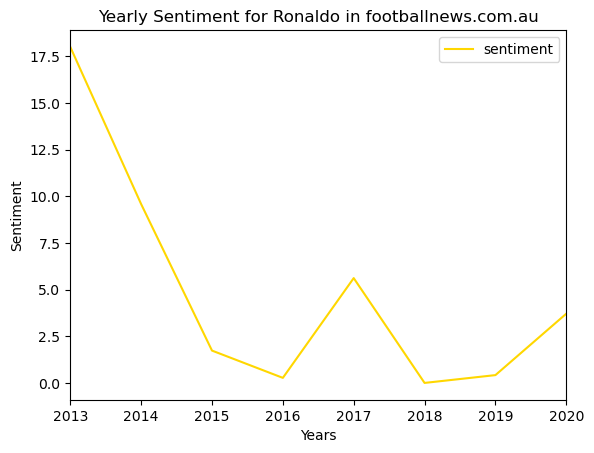

In [122]:
new_topic_senti_series_ronaldo = text_senti_series_ronaldo.resample('1Y').sum()
new_topic_senti_series_ronaldo.plot(label='Ronaldo', color='gold')
plt.title("Yearly Sentiment for Ronaldo in footballnews.com.au")
    
plt.xlabel('Years') 
plt.ylabel('Sentiment')
plt.savefig('yearlySentiment_ronaldo2013.png')

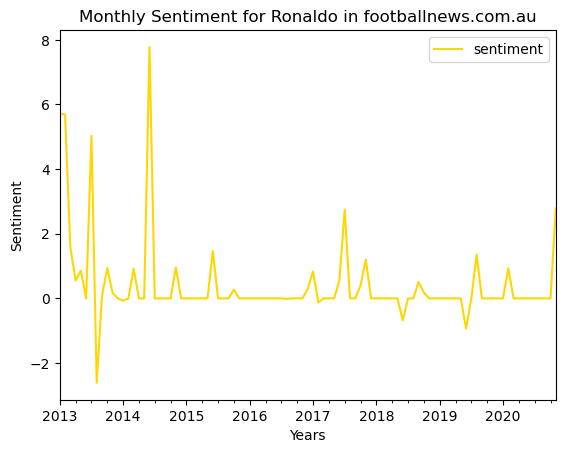

In [124]:
new_topic_senti_series_ronaldo = text_senti_series_ronaldo.resample('1M').sum()
new_topic_senti_series_ronaldo.plot(label='Ronaldo', color='gold')
plt.title("Monthly Sentiment for Ronaldo in footballnews.com.au")
    
plt.xlabel('Years') 
plt.ylabel('Sentiment')
plt.savefig('monthlySentiment_ronaldo2013.png')

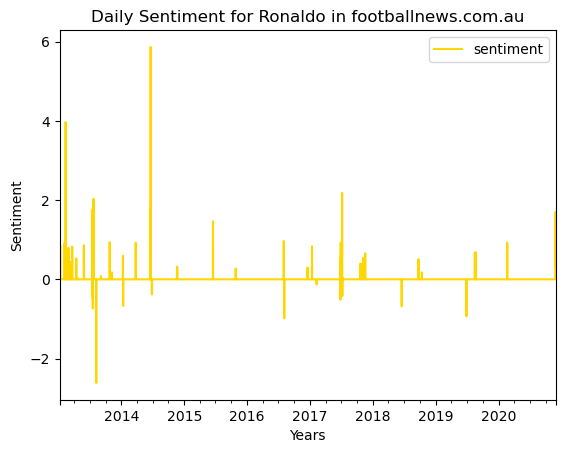

In [125]:
new_topic_senti_series_ronaldo = text_senti_series_ronaldo.resample('1D').sum()
new_topic_senti_series_ronaldo.plot(label='Ronaldo', color='gold')
plt.title("Daily Sentiment for Ronaldo in footballnews.com.au")
    
plt.xlabel('Years') 
plt.ylabel('Sentiment')
plt.savefig('dailySentiment_ronaldo2013.png')

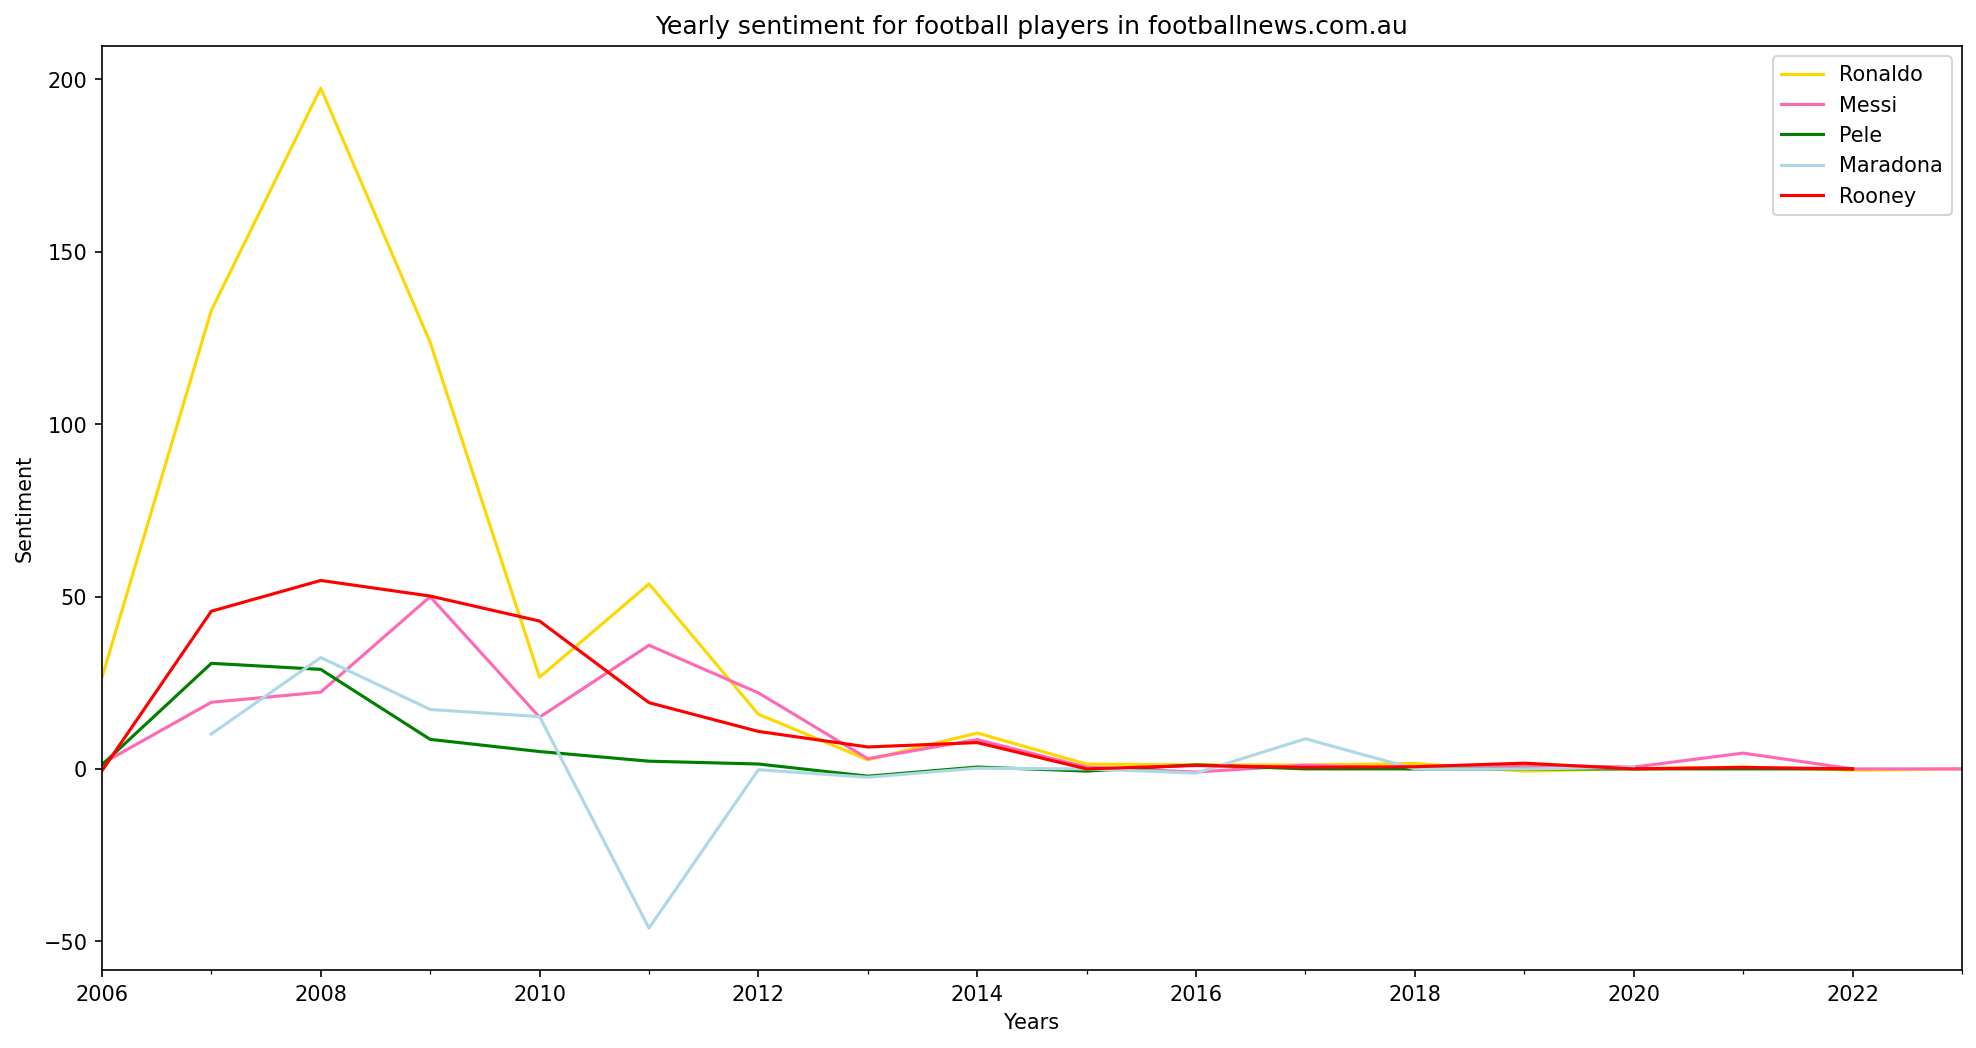

In [99]:
comparePlotTS(playerNames, topic_senti_series_list, '1Y', 'sentiment')
plt.savefig('yearlySentiment_topic_graph.png')

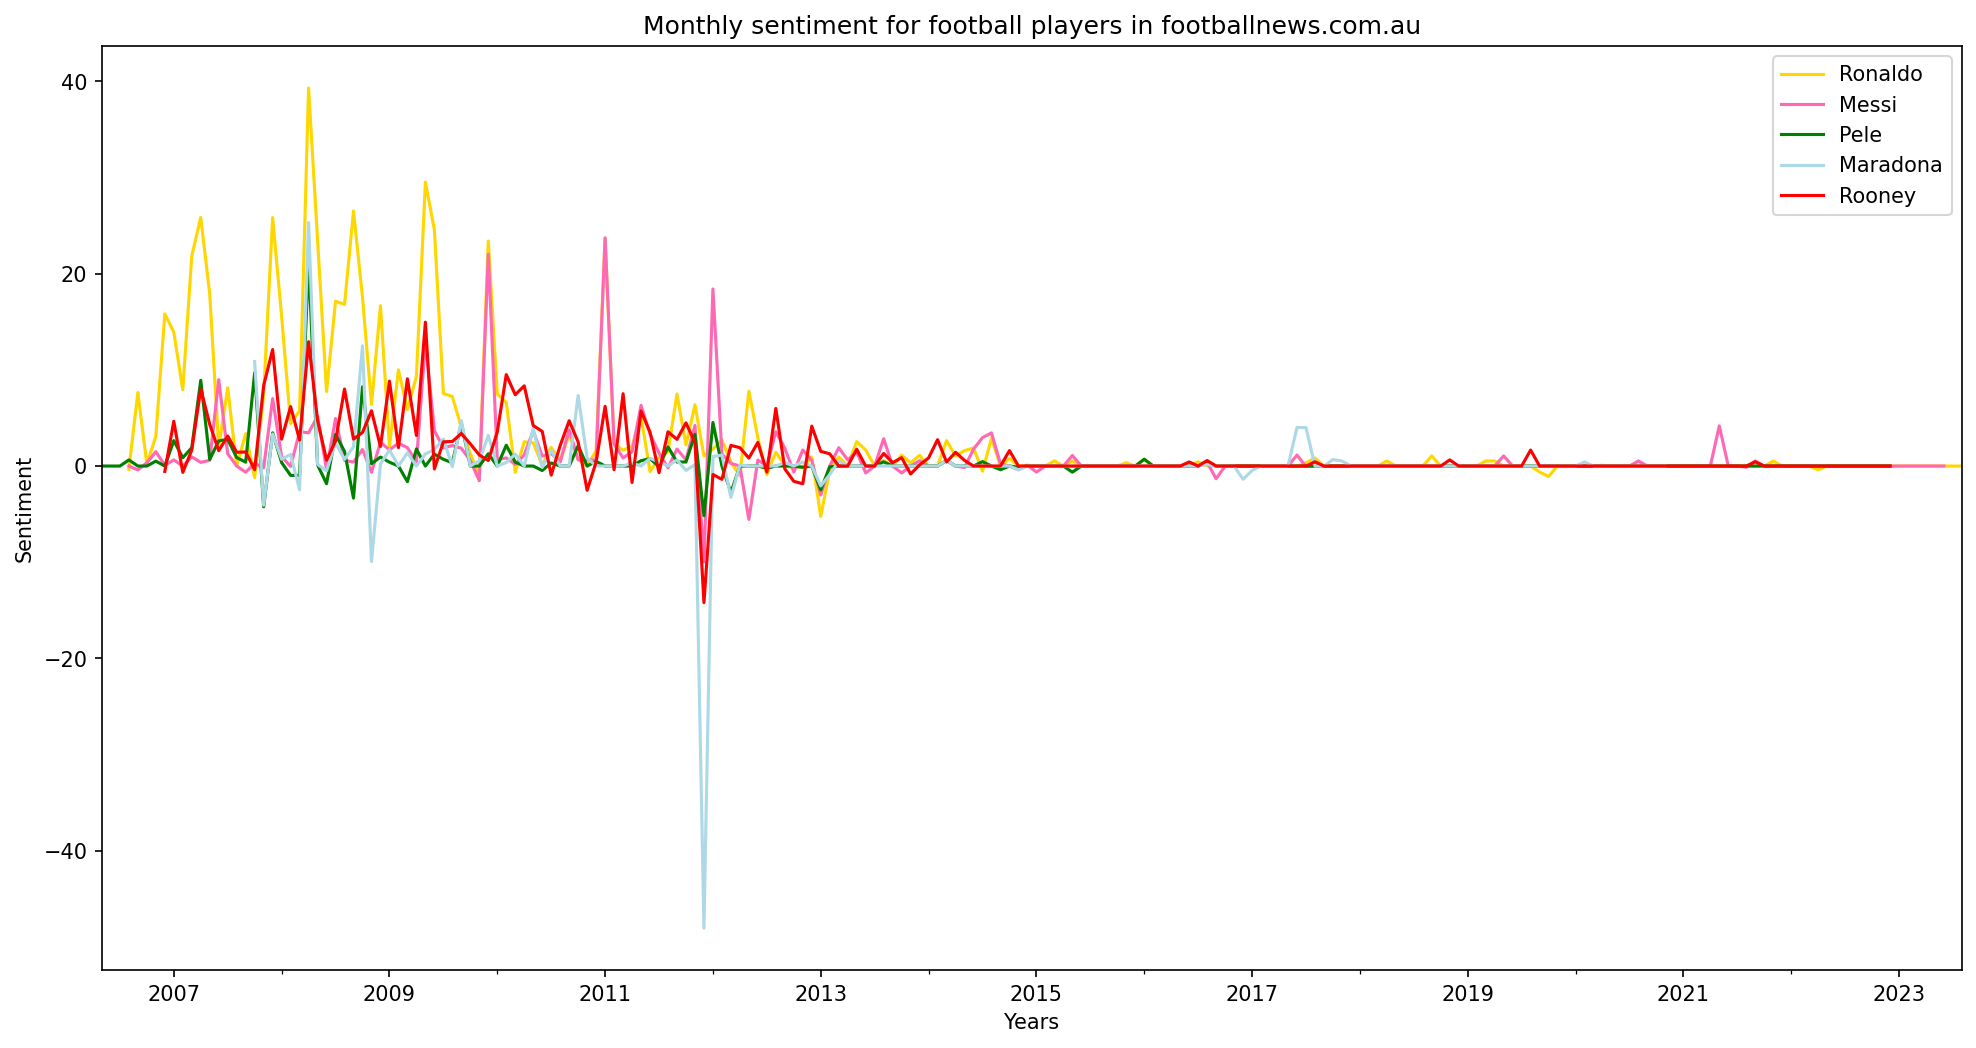

In [100]:
comparePlotTS(playerNames, topic_senti_series_list, '1M', 'sentiment')
plt.savefig('monthlySentiment_topic_graph.png')

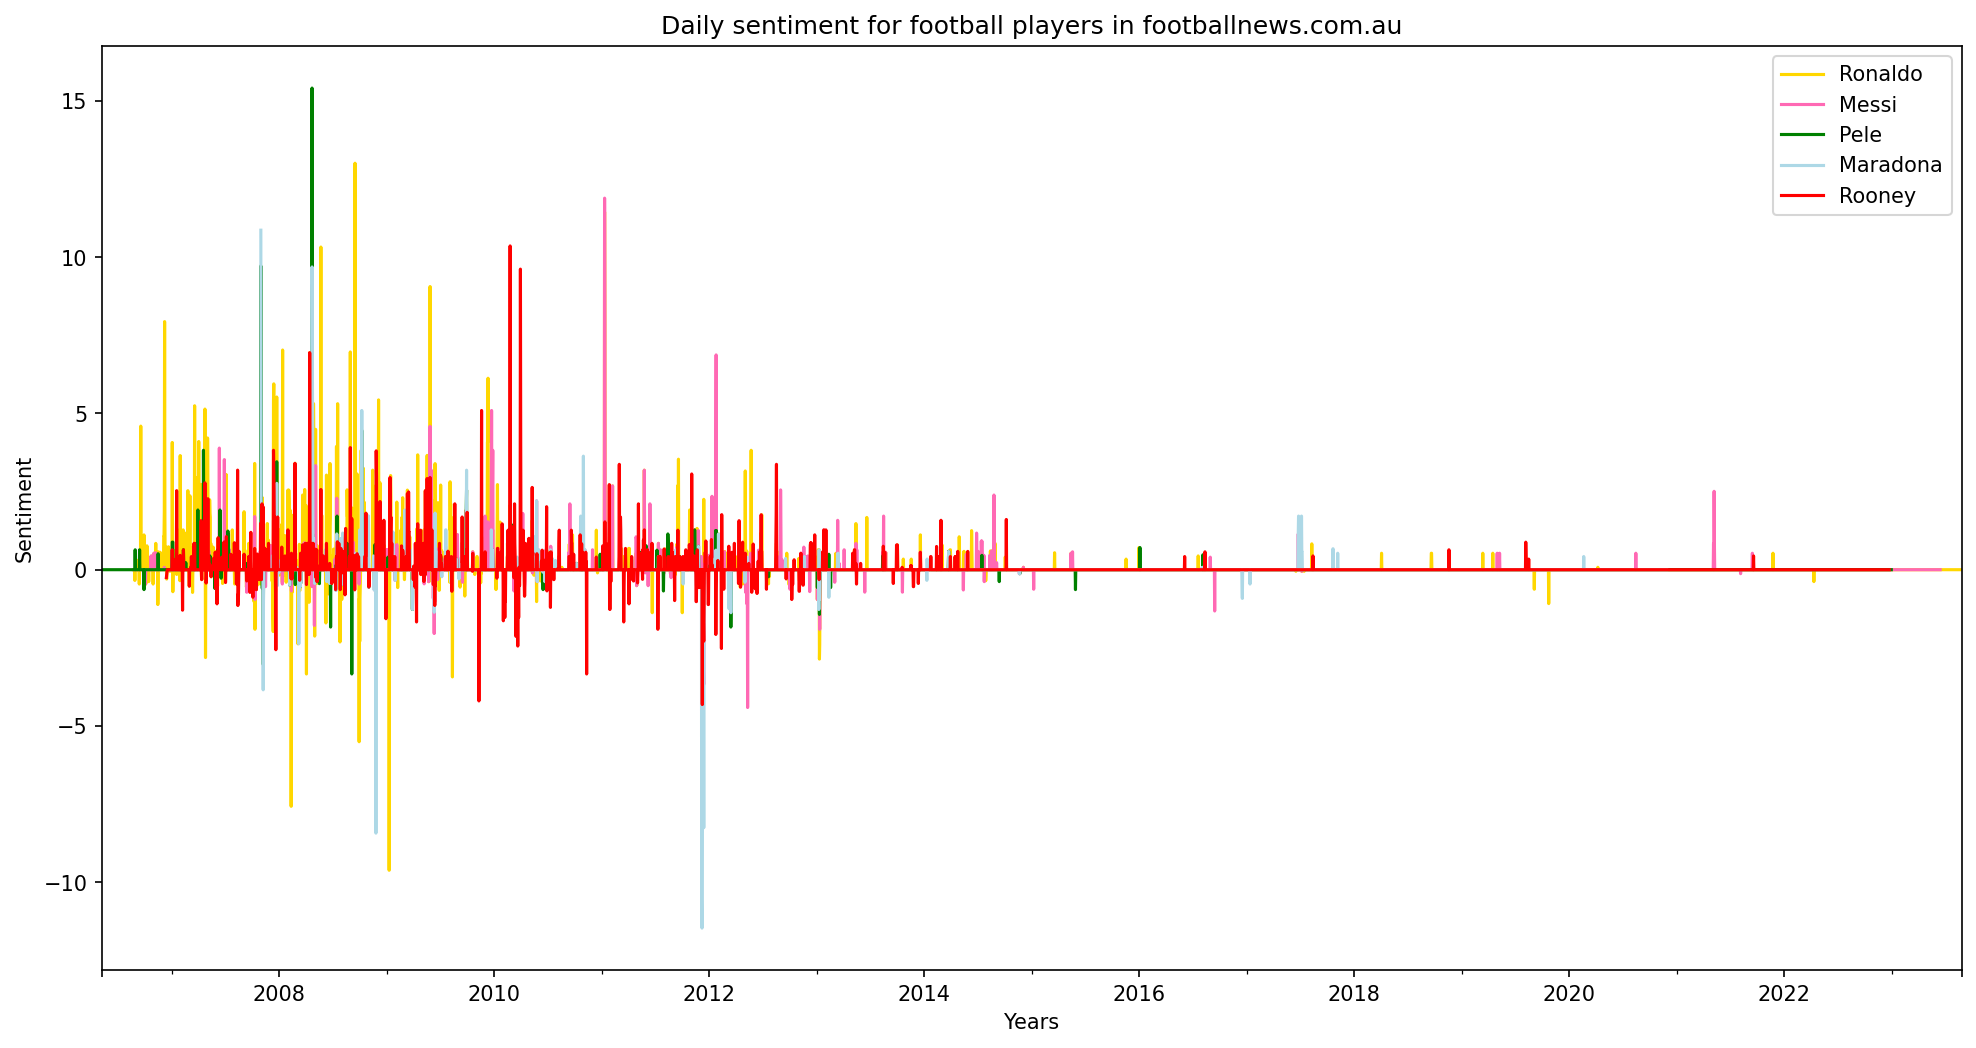

In [101]:
comparePlotTS(playerNames, topic_senti_series_list, '1D', 'sentiment')
plt.savefig('dailySentiment_topic_graph.png')

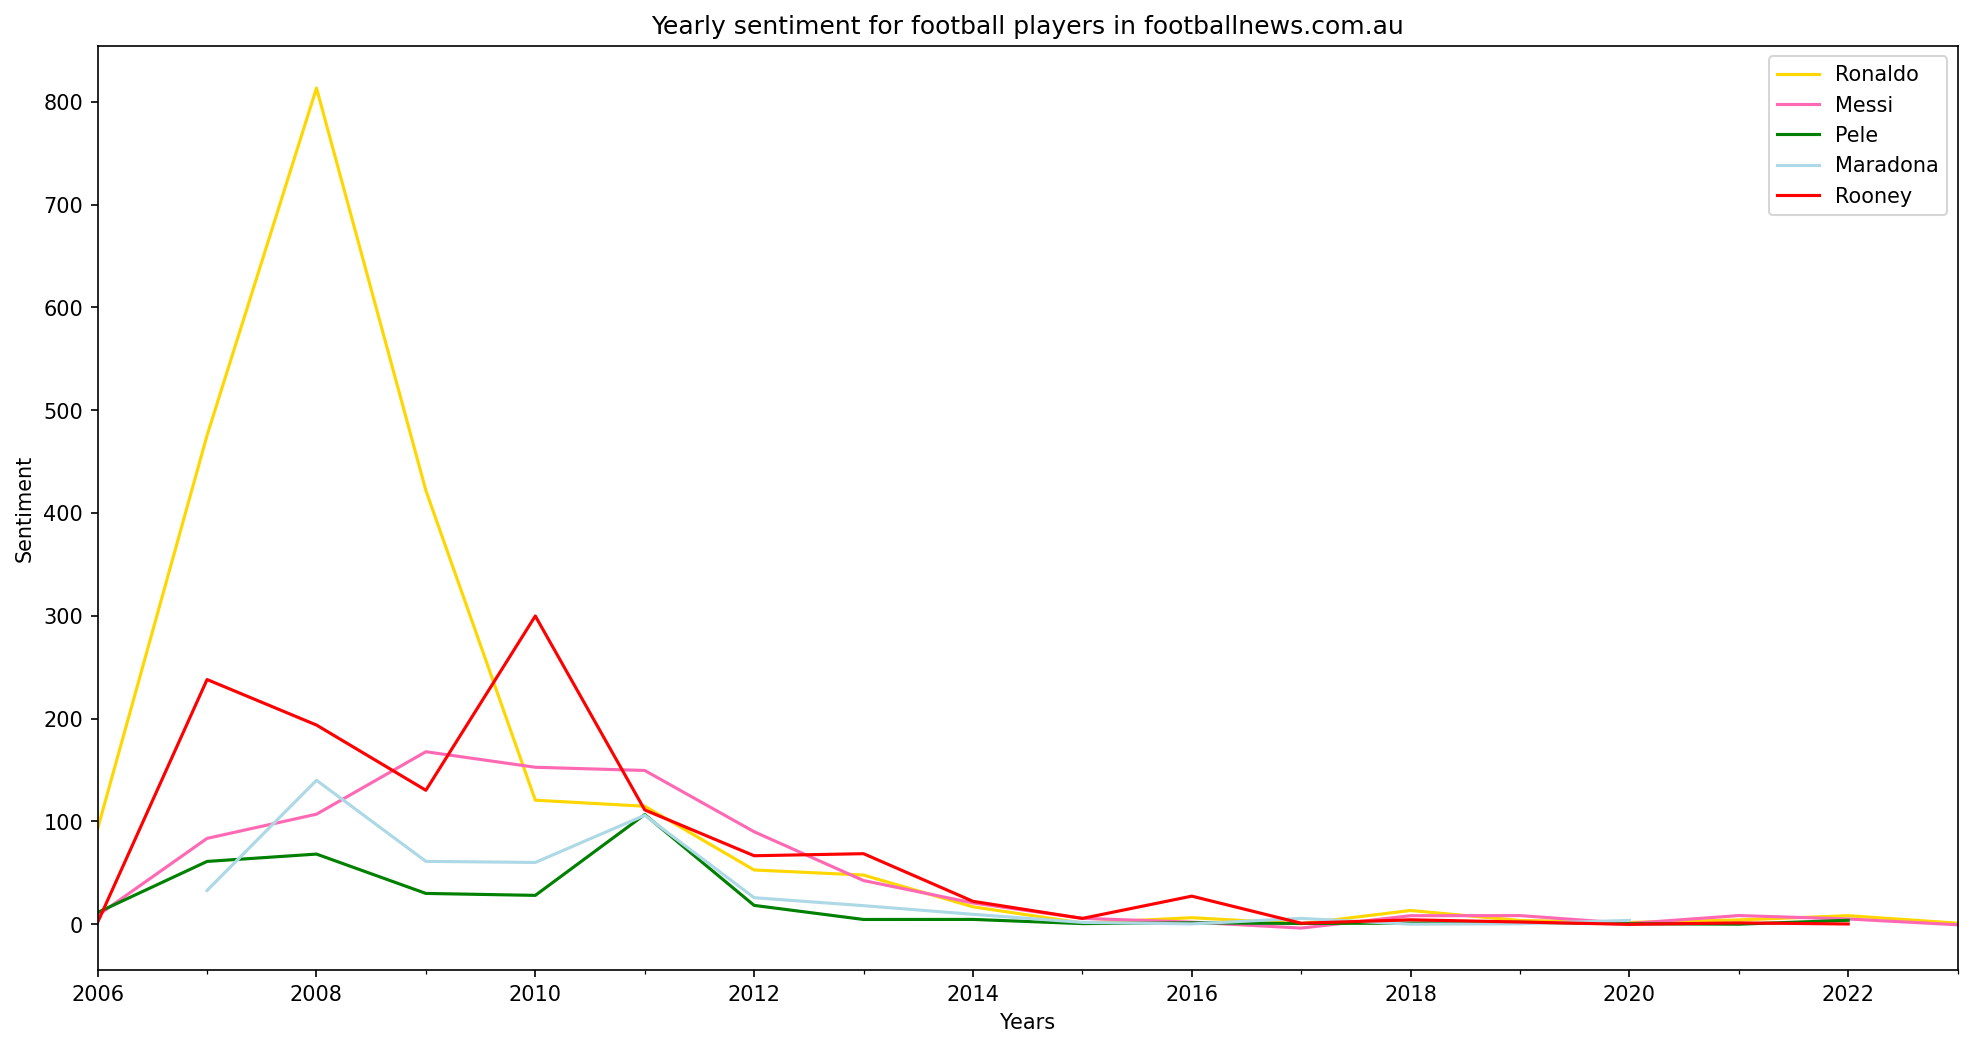

In [94]:
comparePlotTS(playerNames, text_senti_series_list, '1Y', 'sentiment')
plt.savefig('yearlySentiment_graph.png')

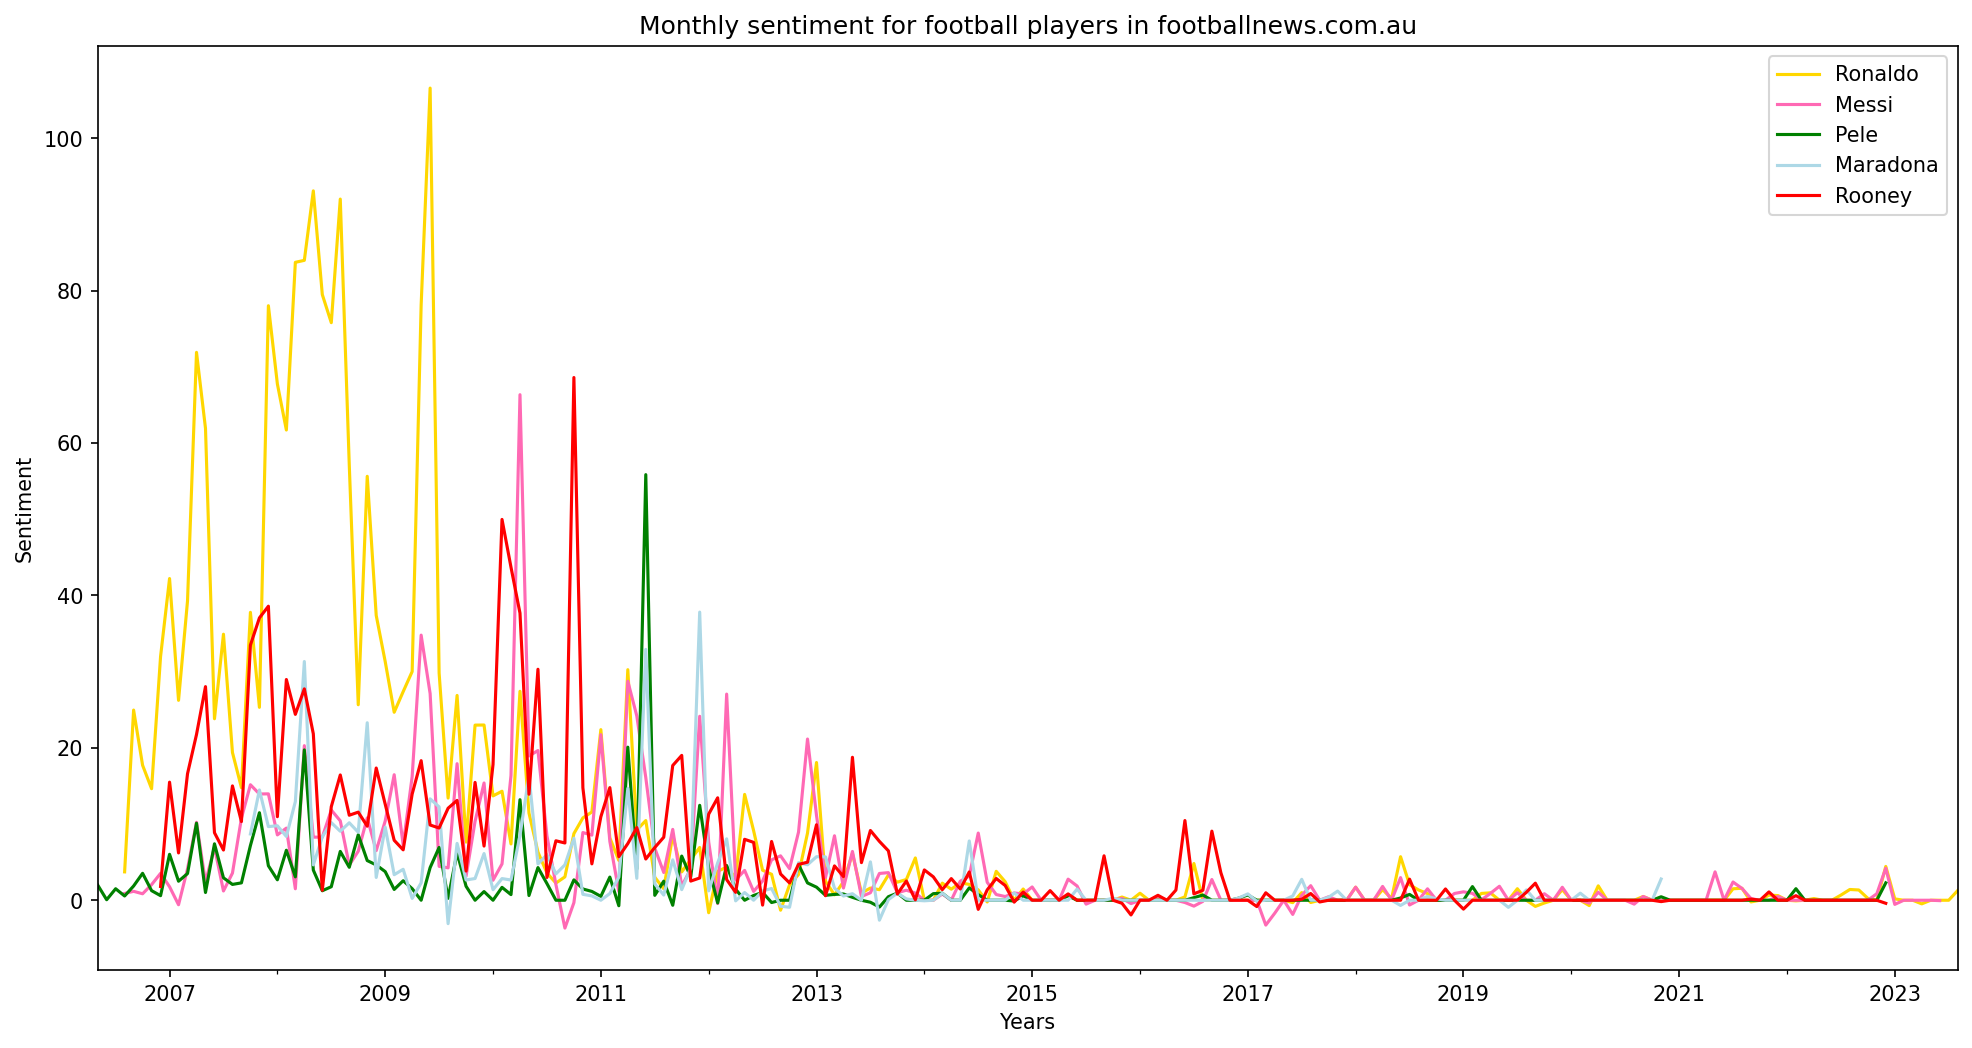

In [95]:
comparePlotTS(playerNames, text_senti_series_list, '1M', 'sentiment')
plt.savefig('monthlySentiment_graph.png')

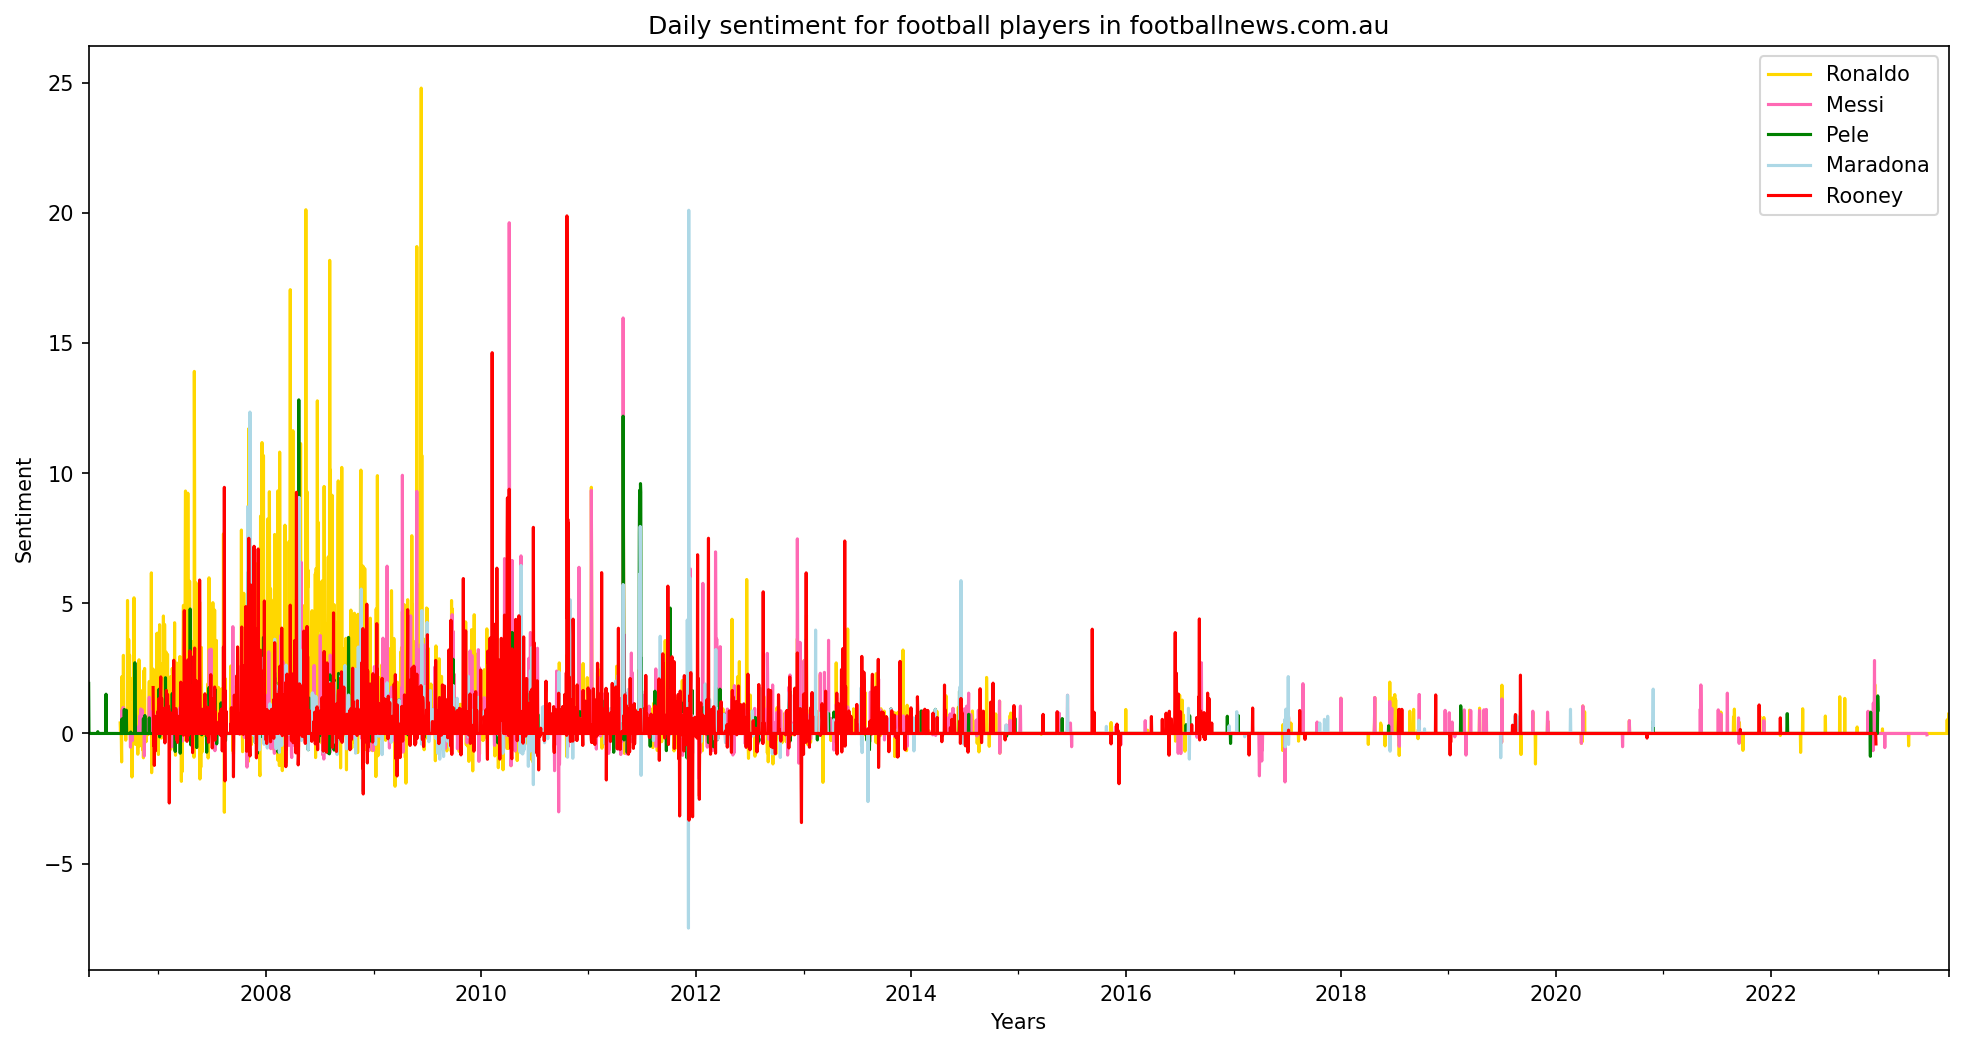

In [96]:
comparePlotTS(playerNames, text_senti_series_list, '1D', 'sentiment')
plt.savefig('dailySentiment_graph.png')